In [1]:
import os
import shutil
import warnings
from itertools import combinations

import numpy as np
import pandas as pd
import yaml
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.signal import savgol_filter, medfilt
import starbars

from towbintools.foundation import file_handling
from towbintools.foundation.utils import interpolate_nans
from towbintools.data_analysis import (
    compute_larval_stage_duration,
    compute_series_at_time_classified,
    filter_series_with_classification,
    rescale_and_aggregate,
    rescale_series,
)
from plotting_functions import (
    combine_experiments,
    plot_aggregated_series,
    plot_correlation,
    plot_correlation_at_ecdysis,
    boxplot_at_molt,
    plot_growth_curves_individuals,
    plot_deviation_from_model_at_ecdysis,
    plot_normalized_proportions,
    plot_deviation_from_model,
    get_most_average_deviations_at_ecdysis,
    get_most_average_proportions_at_ecdysis,
    get_most_average_size_at_ecdysis,
    plot_developmental_success,
    plot_arrests,
    plot_heterogeneity_at_ecdysis,
    plot_heterogeneity_rescaled_data,
    build_legend,
    combine_series,
    transform_series,
    compute_growth_rate,
    rescale,
)

# Configure warnings
warnings.filterwarnings("once")

In [2]:
filemap_paths = [
    "/mnt/towbin.data/shared/spsalmon/20250127_ORCA_10x_chambers_for_lucien/analysis_sacha/report/analysis_filemap_annotated.csv",
]

conditions_paths = [
    "/mnt/towbin.data/shared/spsalmon/20250127_ORCA_10x_chambers_for_lucien/doc/conditions.yaml",
]

organ_channels = [{'body': 2, 'pharynx' : 1}]

backup_path = "/mnt/towbin.data/shared/spsalmon/plotting_backups/lucien/"

filemap_backup_path = os.path.join(backup_path, "filemaps")
conditions_backup_path = os.path.join(backup_path, "conditions")
structure_backup_path = os.path.join(backup_path, "structure")

os.makedirs(backup_path, exist_ok=True)
os.makedirs(filemap_backup_path, exist_ok=True)
os.makedirs(conditions_backup_path, exist_ok=True)
os.makedirs(structure_backup_path, exist_ok=True)

for i, (filemap_path, config_path) in enumerate(zip(filemap_paths, conditions_paths)):
    output_name = f"analysis_filemap_{i}.csv"
    output_name_config = f"config_{i}.yaml"
    
    # Copy the filemap to the backup path
    shutil.copy(filemap_path, os.path.join(filemap_backup_path, output_name))
    shutil.copy(config_path, os.path.join(conditions_backup_path, output_name_config))

# Copy the current working directory to the backup path
current_dir = os.getcwd()
current_dir_name = os.path.basename(current_dir)
destination = os.path.join(backup_path, current_dir_name)

shutil.copytree(current_dir, destination, dirs_exist_ok=True)

print("Backup completed successfully!")

Backup completed successfully!


In [3]:
import pickle
conditions_struct = combine_experiments(filemap_paths, conditions_paths, organ_channels=organ_channels, recompute_values_at_molt=False)

# backup the conditions struct
with open(os.path.join(structure_backup_path, "plotting_struct.pkl"), "wb") as f:
    pickle.dump(conditions_struct, f)

In [4]:
for condition in conditions_struct:
    print(f"Condition: {condition['condition_id'], {condition['description']}}, Number of individuals: {condition['ecdysis_time_step'].shape[0]}")

Condition: (0, {'wBT160'}), Number of individuals: 6


In [5]:
# change figure size to your liking
plt.rcParams['figure.figsize'] = [12, 10]

# make lines thicker
plt.rcParams['lines.linewidth'] = 2

# make font size bigger
plt.rcParams.update({'font.size': 12})

In [6]:
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_mean_at_ecdysis', 'body_seg_str_length_at_ecdysis', 'divide', 'body_seg_str_aspect_ratio_at_ecdysis')
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_length', 'divide', 'body_seg_str_aspect_ratio')
conditions_struct = combine_series(conditions_struct, 'body_seg_str_width_max_at_ecdysis', 'body_seg_str_width_mean_at_ecdysis', 'subtract', 'body_seg_str_width_max_minus_mean_at_ecdysis')

conditions_struct = combine_series(conditions_struct, 'pharynx_seg_str_width_mean_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', 'divide', 'pharynx_seg_str_aspect_ratio_at_ecdysis')
conditions_struct = combine_series(conditions_struct, 'pharynx_seg_str_width_mean', 'pharynx_seg_str_length', 'divide', 'pharynx_seg_str_aspect_ratio')

conditions_struct = transform_series(conditions_struct, 'body_seg_str_width_mean', 'log', 'body_seg_str_log_width_mean')
conditions_struct = transform_series(conditions_struct, 'body_seg_str_length', 'log', 'body_seg_str_log_length')
conditions_struct = transform_series(conditions_struct, 'body_seg_str_volume', 'log', 'body_seg_str_log_volume')

conditions_struct = transform_series(conditions_struct, 'pharynx_seg_str_width_mean', 'log', 'pharynx_seg_str_log_width_mean')
conditions_struct = transform_series(conditions_struct, 'pharynx_seg_str_length', 'log', 'pharynx_seg_str_log_length')
conditions_struct = transform_series(conditions_struct, 'pharynx_seg_str_volume', 'log', 'pharynx_seg_str_log_volume')

In [7]:

# COMPUTE GROWTH RATES
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_volume', 'body_seg_str_volume_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_width_mean_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_length', 'body_seg_str_length_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_aspect_ratio', 'body_seg_str_aspect_ratio_growth_rate')

conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_volume', 'pharynx_seg_str_volume_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_width_mean', 'pharynx_seg_str_width_mean_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_length', 'pharynx_seg_str_length_growth_rate')
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_aspect_ratio', 'pharynx_seg_str_aspect_ratio_growth_rate')

# COMPUTE GROWTH RATES FOR LOG TRANSFORMED SERIES
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_width_mean', 'body_seg_str_log_width_mean_growth_rate', experiment_time=False)
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_length', 'body_seg_str_log_length_growth_rate', experiment_time=False)
conditions_struct = compute_growth_rate(conditions_struct, 'body_seg_str_log_volume', 'body_seg_str_log_volume_growth_rate', experiment_time=False)

conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_log_width_mean', 'pharynx_seg_str_log_width_mean_growth_rate', experiment_time=False)
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_log_length', 'pharynx_seg_str_log_length_growth_rate', experiment_time=False)
conditions_struct = compute_growth_rate(conditions_struct, 'pharynx_seg_str_log_volume', 'pharynx_seg_str_log_volume_growth_rate', experiment_time=False)

# RESCALE GROWTH RATES
conditions_struct = rescale(conditions_struct, 'body_seg_str_volume_growth_rate', 'body_seg_str_volume_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_mean_growth_rate', 'body_seg_str_width_mean_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_length_growth_rate', 'body_seg_str_length_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_aspect_ratio_growth_rate', 'body_seg_str_aspect_ratio_growth_rate_rescaled')

conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_volume_growth_rate', 'pharynx_seg_str_volume_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_width_mean_growth_rate', 'pharynx_seg_str_width_mean_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_length_growth_rate', 'pharynx_seg_str_length_growth_rate_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_aspect_ratio_growth_rate', 'pharynx_seg_str_aspect_ratio_growth_rate_rescaled')

# RESCALE GROWTH RATES FOR LOG TRANSFORMED SERIES
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_width_mean_growth_rate', 'body_seg_str_log_width_mean_growth_rate_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_length_growth_rate', 'body_seg_str_log_length_growth_rate_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_volume_growth_rate', 'body_seg_str_log_volume_growth_rate_rescaled', experiment_time=False)

conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_log_width_mean_growth_rate', 'pharynx_seg_str_log_width_mean_growth_rate_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_log_length_growth_rate', 'pharynx_seg_str_log_length_growth_rate_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_log_volume_growth_rate', 'pharynx_seg_str_log_volume_growth_rate_rescaled', experiment_time=False)

# RESCALE SERIES
conditions_struct = rescale(conditions_struct, 'body_seg_str_volume', 'body_seg_str_volume_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_mean', 'body_seg_str_width_mean_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_width_max', 'body_seg_str_width_max_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_length', 'body_seg_str_length_rescaled')
conditions_struct = rescale(conditions_struct, 'body_seg_str_aspect_ratio', 'body_seg_str_aspect_ratio_rescaled')

conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_volume', 'pharynx_seg_str_volume_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_width_mean', 'pharynx_seg_str_width_mean_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_length', 'pharynx_seg_str_length_rescaled')
conditions_struct = rescale(conditions_struct, 'pharynx_seg_str_aspect_ratio', 'pharynx_seg_str_aspect_ratio_rescaled')

# RESCALE SERIES FOR LOG TRANSFORMED SERIES

conditions_struct = rescale(conditions_struct, 'body_seg_str_log_width_mean', 'body_seg_str_log_width_mean_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_length', 'body_seg_str_log_length_rescaled', experiment_time=False)
conditions_struct = rescale(conditions_struct, 'body_seg_str_log_volume', 'body_seg_str_log_volume_rescaled', experiment_time=False)

# conditions_to_plot = [4]
# colors = None
# plot_aggregated_series(conditions_struct, ['body_seg_str_aspect_ratio_growth_rate'], conditions_to_plot, colors=colors, experiment_time = True, aggregation='mean', n_points=100, time_step = 14, log_scale = False, legend = {'description': ''})

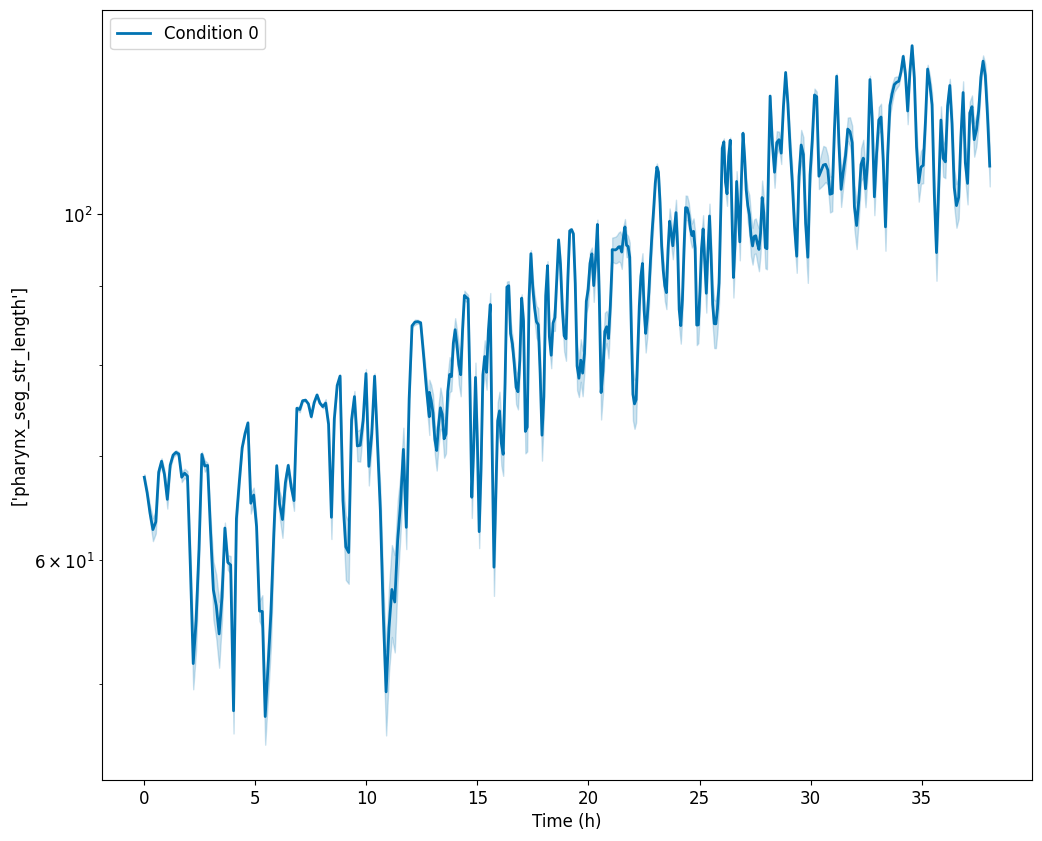

In [8]:
conditions_to_plot = [0]

plot_aggregated_series(conditions_struct, ['pharynx_seg_str_length'], conditions_to_plot, colors=None, experiment_time = True, aggregation='mean', n_points=100, time_step = 14, log_scale = True, legend = None)

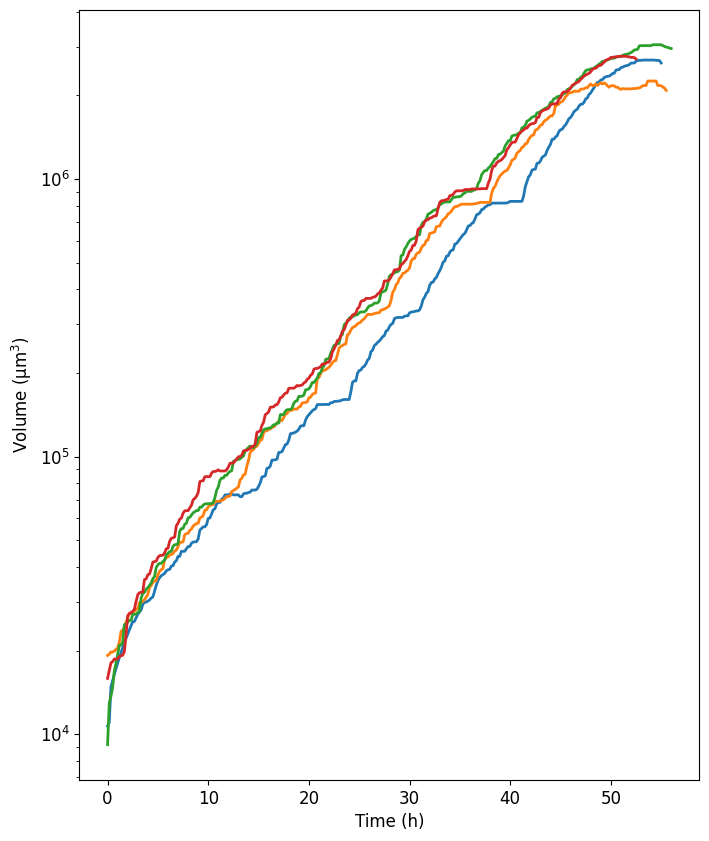

In [34]:
from plotting_functions import set_scale
from towbintools.data_analysis import correct_series_with_classification

def plot_growth_curves_individuals(
    conditions_struct,
    column,
    conditions_to_plot,
    log_scale=True,
    color_palette="colorblind",
    figsize=None,
    legend=None,
    y_axis_label=None,
    output_dir="/home/spsalmon"
):
    import pandas as pd
    import numpy as np
    
    color_palette = sns.color_palette(color_palette, len(conditions_to_plot))
    if figsize is None:
        figsize = (len(conditions_to_plot) * 8, 10)
    
    fig, ax = plt.subplots(1, len(conditions_to_plot), figsize=figsize)
    
    # Create a list to store all the data for CSV export
    csv_data = []
    
    for i, condition_id in enumerate(conditions_to_plot):
        condition_dict = conditions_struct[condition_id]
        # TEMPORARY, ONLY WORKS WITH SINGLE CLASSIFICATION, FIND A WAY TO GENERALIZE
        worm_type_key = [key for key in condition_dict.keys() if "worm_type" in key][0]
        
        for j in range(len(condition_dict[column])):
            time = condition_dict["experiment_time"][j]/3600
            data = condition_dict[column][j]
            worm_type = condition_dict[worm_type_key][j]
            hatch = condition_dict['ecdysis_time_step'][j][0]
            hatch_experiment_time = condition_dict['ecdysis_experiment_time'][j][0]/3600
            
            if not np.isnan(hatch):
                hatch = int(hatch)
                time = time[hatch:]
                time = time - hatch_experiment_time
                data = data[hatch:]
                worm_type = worm_type[hatch:]
                filtered_data = correct_series_with_classification(data, worm_type)
                # smooth the data
                filtered_data = medfilt(filtered_data, 21)
                label = build_legend(condition_dict, legend)
                
                # Store the data for CSV export
                for t, val in zip(time, filtered_data):
                    csv_data.append({
                        'condition': condition_id,
                        'worm_number': j,
                        'time_hours': t,
                        column: val
                    })
                
                try:
                    ax[i].plot(time, filtered_data)
                    set_scale(ax[i], log_scale)
                except TypeError:
                    ax.plot(time, filtered_data)
                    set_scale(ax, log_scale)
    
    # Set labels
    if y_axis_label is not None:
        try:
            ax[0].set_ylabel(y_axis_label)
            ax[0].set_xlabel("Time (h)")
        except TypeError:
            ax.set_ylabel(y_axis_label)
            ax.set_xlabel("Time (h)")
    else:
        try:
            ax[0].set_ylabel(column)
            ax[0].set_xlabel("Time (h)")
        except TypeError:
            ax.set_ylabel(column)
            ax.set_xlabel("Time (h)")
    
    # Save the plot
    plt.savefig(f"{output_dir}/{column}_growth_curves_individuals.svg")
    plt.show()
    
    # Export the data to CSV
    df = pd.DataFrame(csv_data)
    csv_filename = f"{output_dir}/{column}_growth_curves_data.csv"
    df.to_csv(csv_filename, index=False)

conditions_to_plot = [0]
plot_growth_curves_individuals(conditions_struct, 'body_seg_str_volume', conditions_to_plot, log_scale = True, legend = None, y_axis_label = 'Volume ($\mathrm{\mu m^3}$)')

IndexError: list index out of range

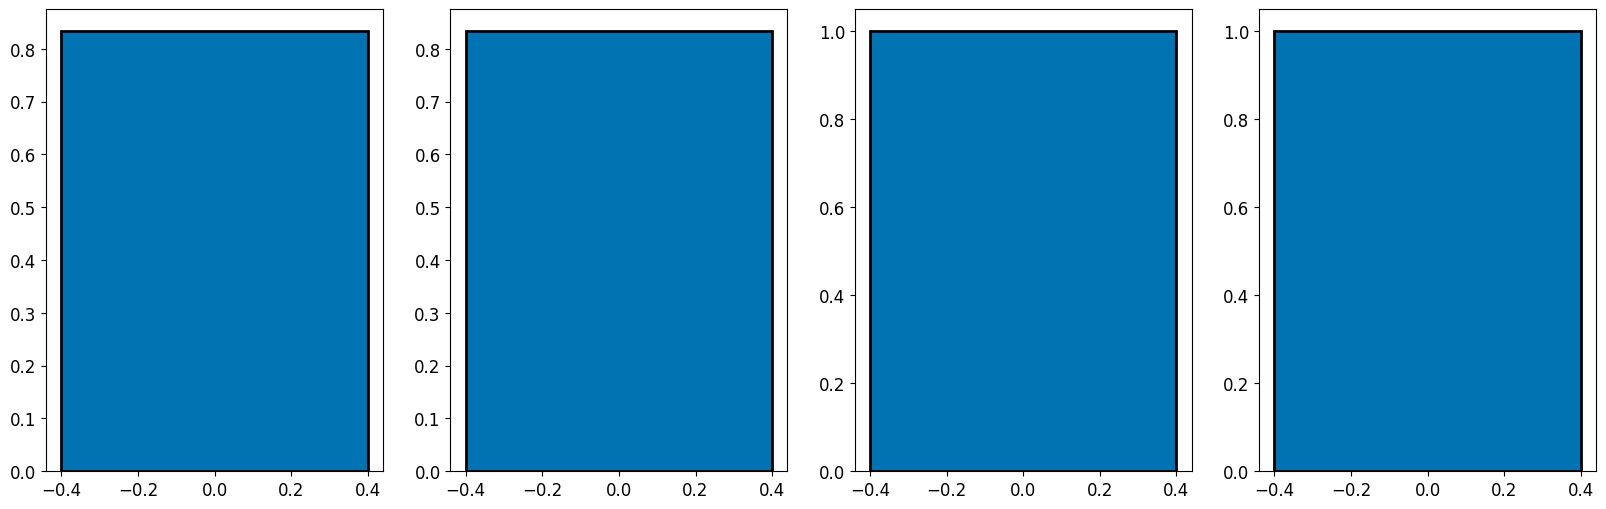

In [10]:
conditions_to_plot = [0, 4]
plot_developmental_success(conditions_struct, conditions_to_plot, legend = {'description': ''})

## yap-1 loss makes worms dumpy

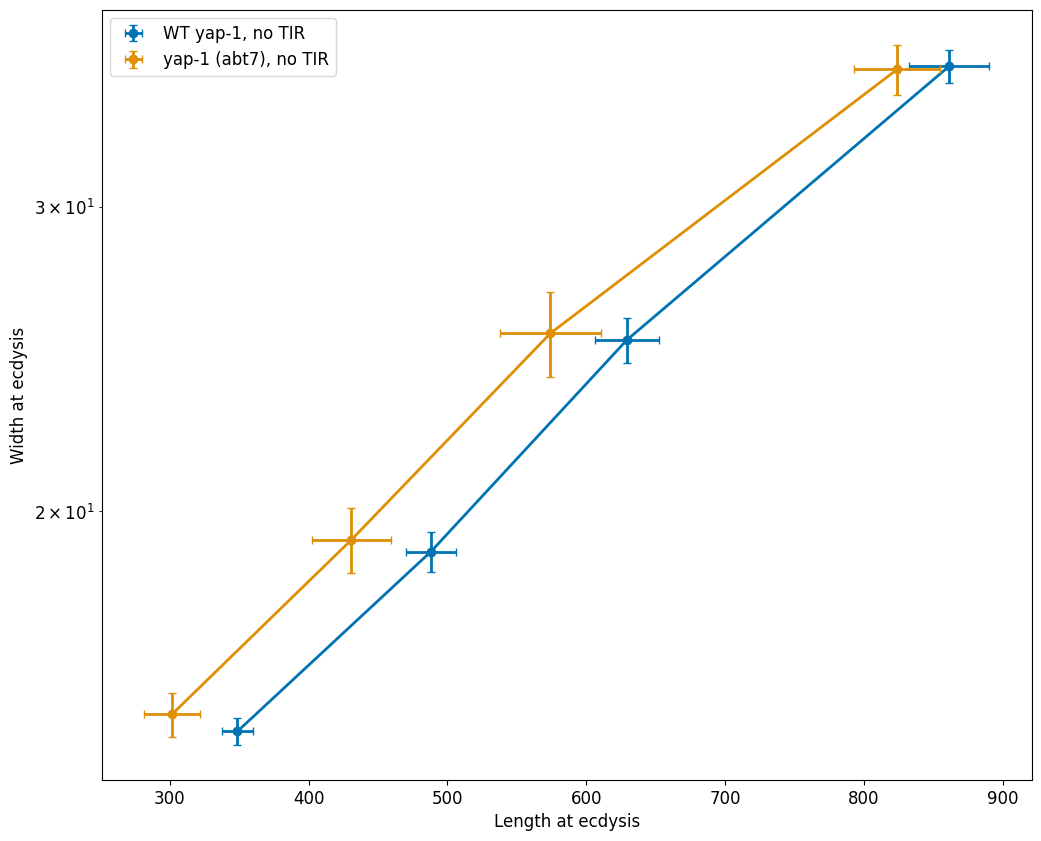

In [ ]:
conditions_to_plot = [0, 4]
colors = None

plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'body_seg_str_width_mean_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (False, True), legend = {'description': ''}, y_axis_label='Width at ecdysis', x_axis_label='Length at ecdysis')

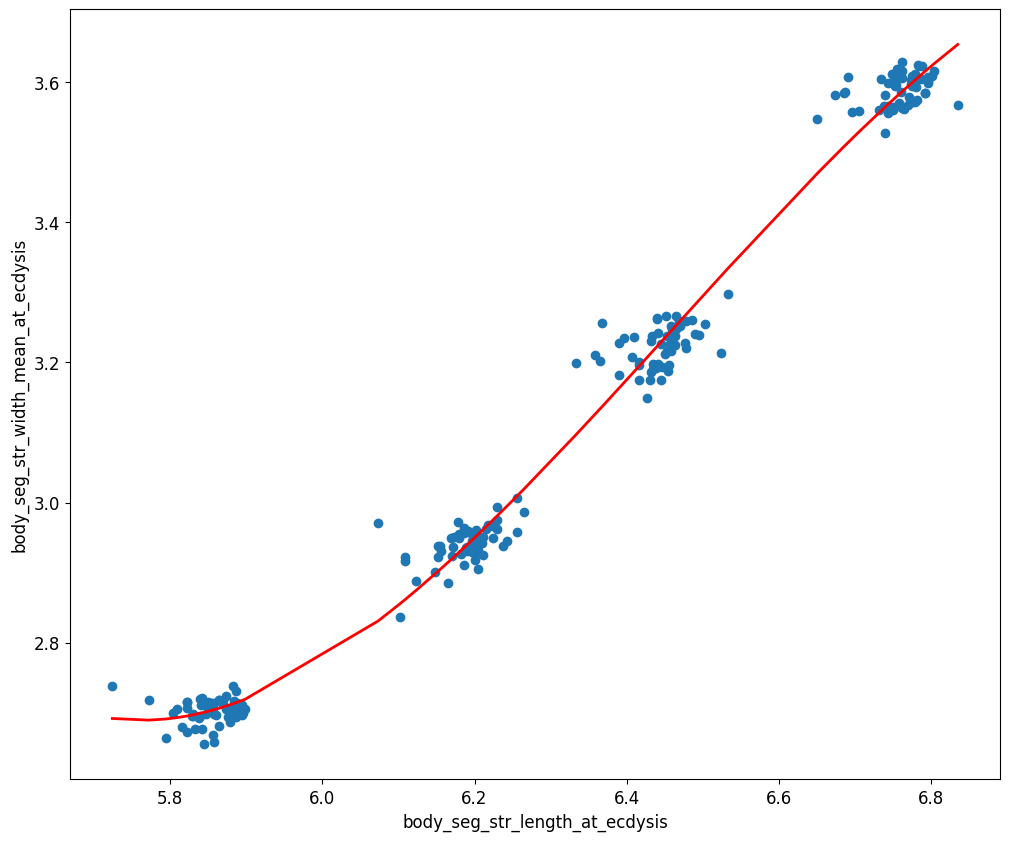

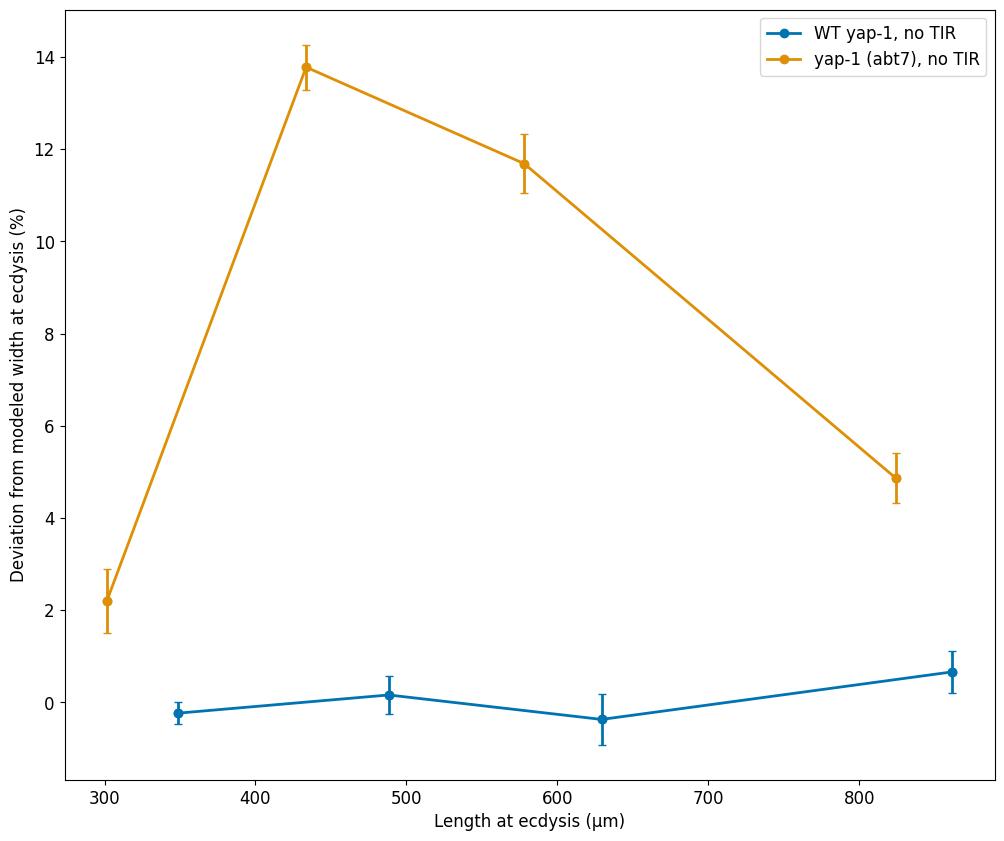

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_length_at_ecdysis", "body_seg_str_width_mean_at_ecdysis", control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = False, legend = {'description': ''}, x_axis_label='Length at ecdysis (µm)', y_axis_label='Deviation from modeled width at ecdysis (%)')

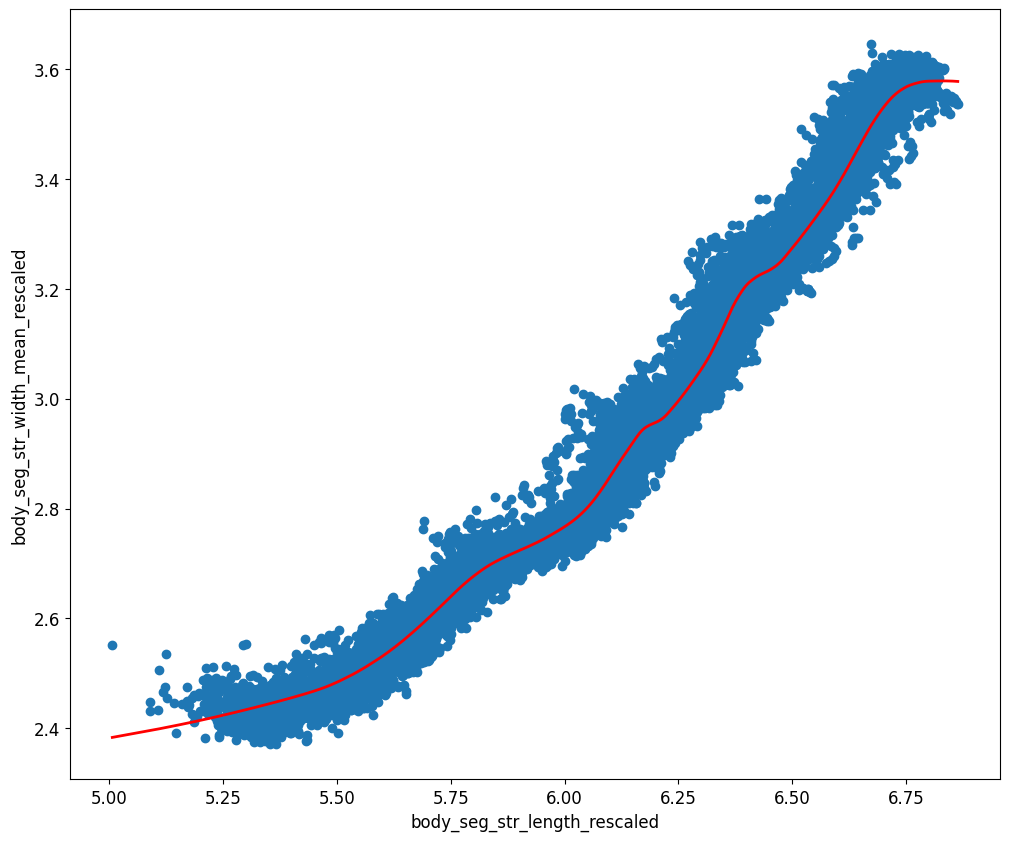

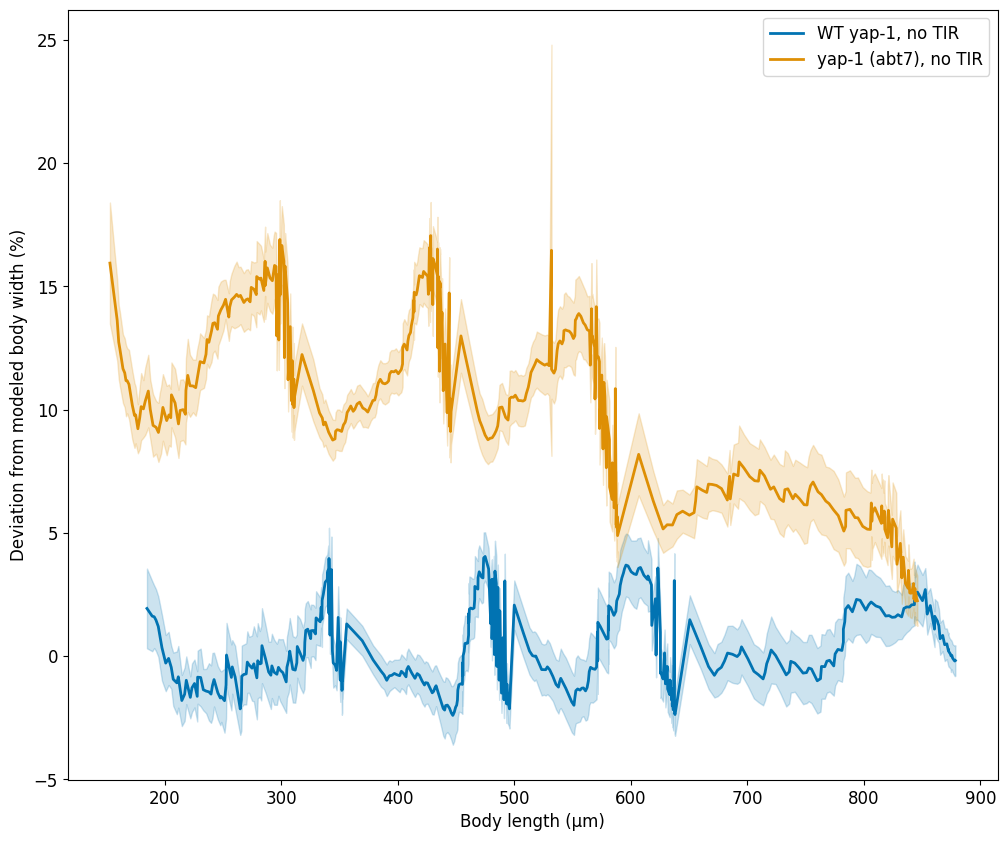

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
plot_deviation_from_model(conditions_struct, "body_seg_str_length_rescaled", "body_seg_str_width_mean_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Body length (µm)', y_axis_label='Deviation from modeled body width (%)')

## yap-1 loss leads to width irregularities

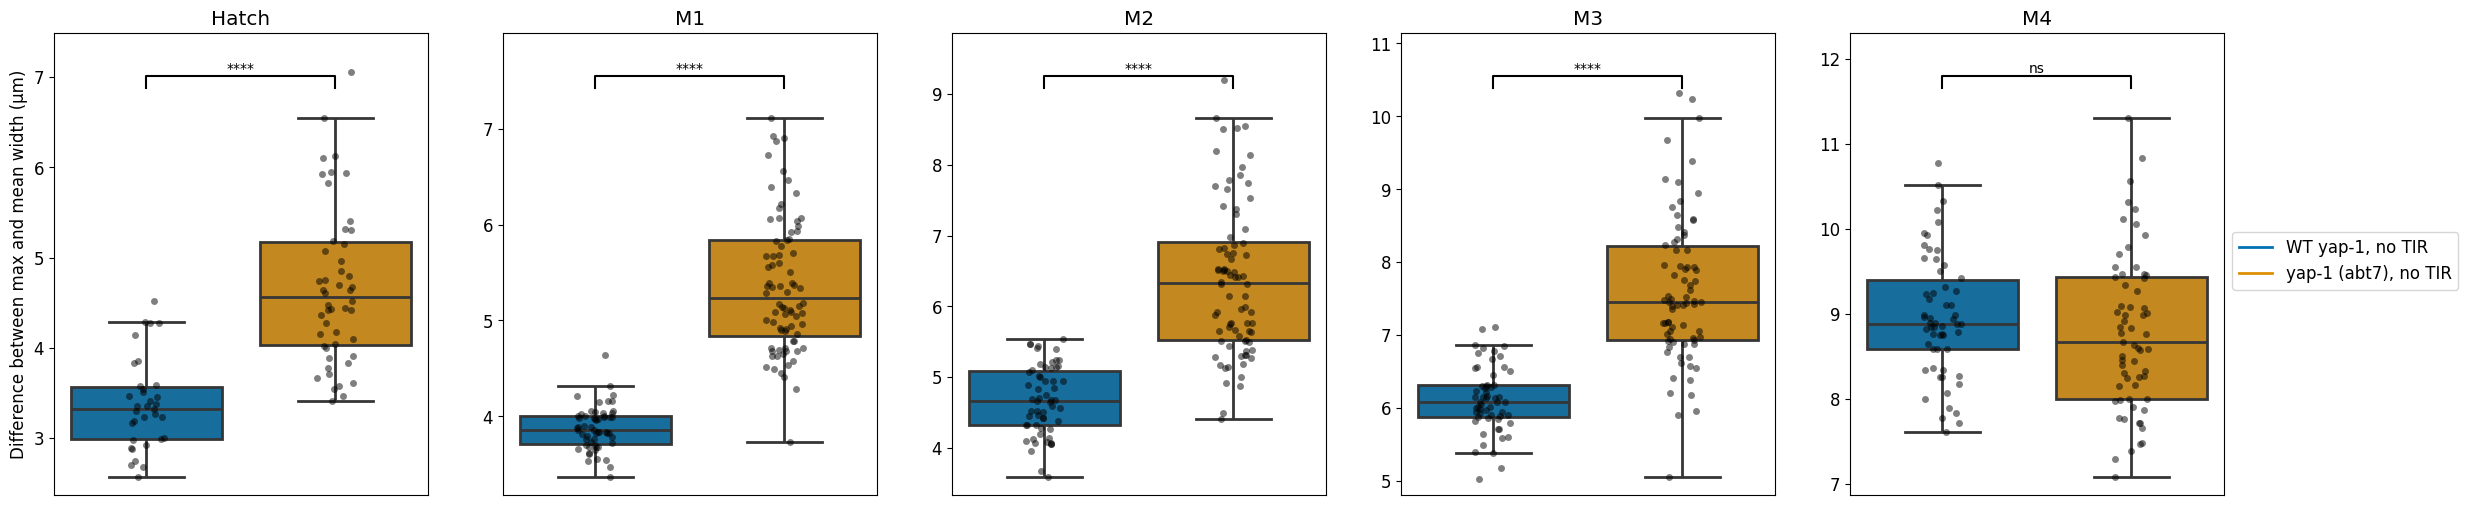

In [ ]:
boxplot_at_molt(conditions_struct, 'body_seg_str_width_max_minus_mean_at_ecdysis', [0, 4], log_scale = False, plot_significance=True, legend = {'description': ''}, y_axis_label="Difference between max and mean width (µm)", titles = ['Hatch', 'M1', 'M2', 'M3', 'M4'])

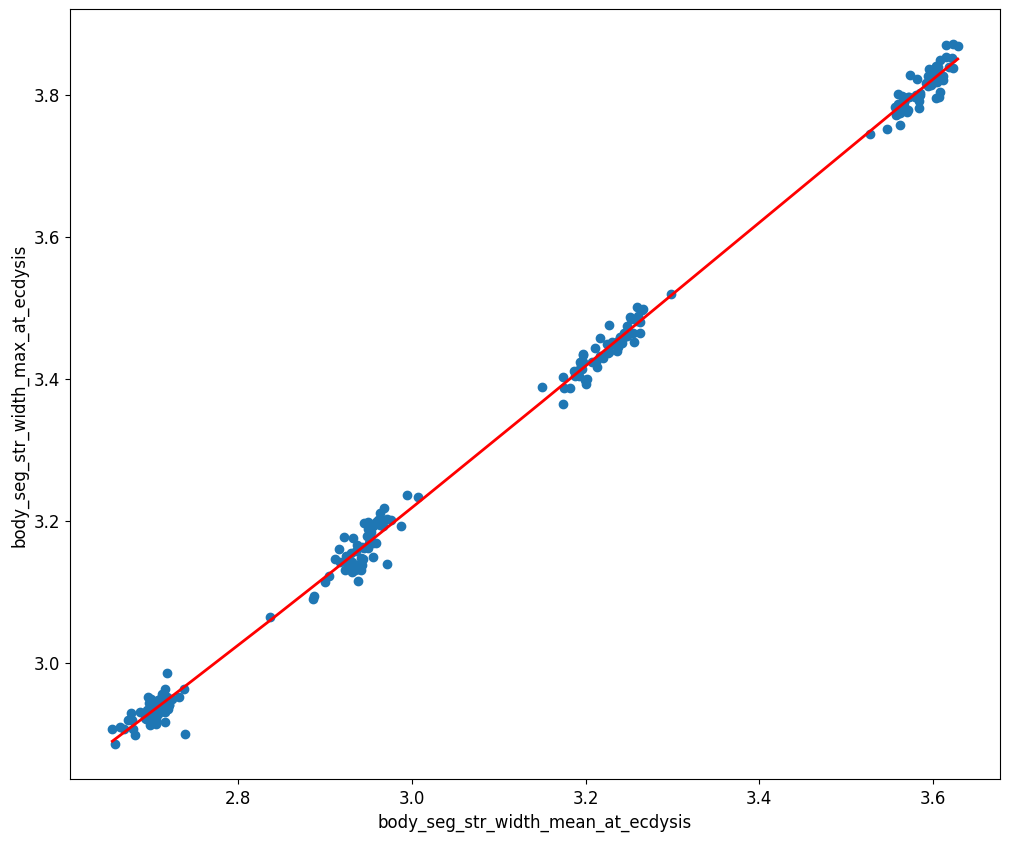

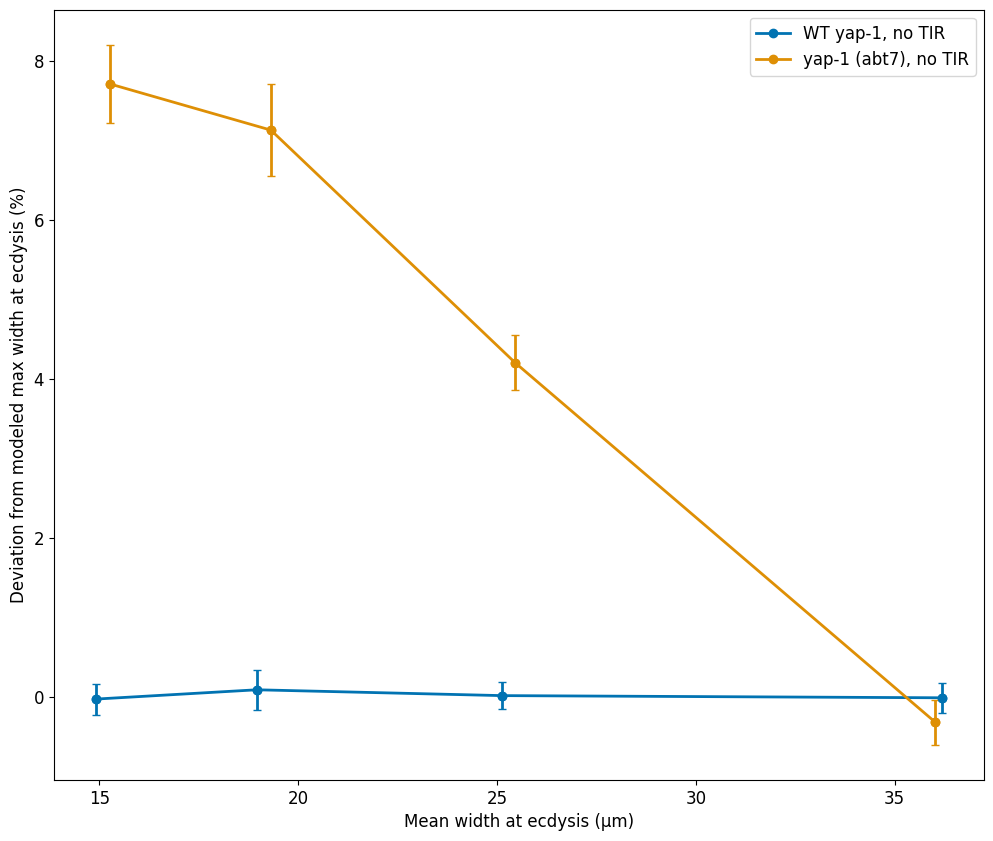

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, "body_seg_str_width_mean_at_ecdysis", "body_seg_str_width_max_at_ecdysis", control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = False, legend = {'description': ''}, x_axis_label='Mean width at ecdysis (µm)', y_axis_label='Deviation from modeled max width at ecdysis (%)')

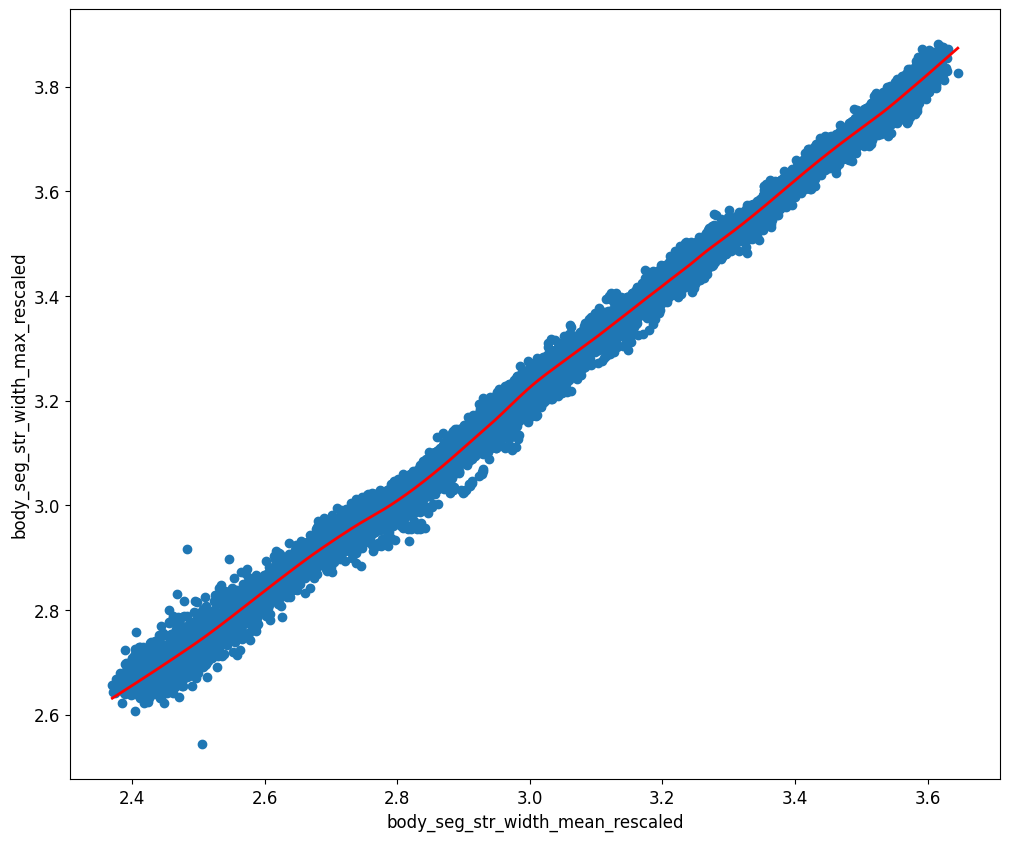

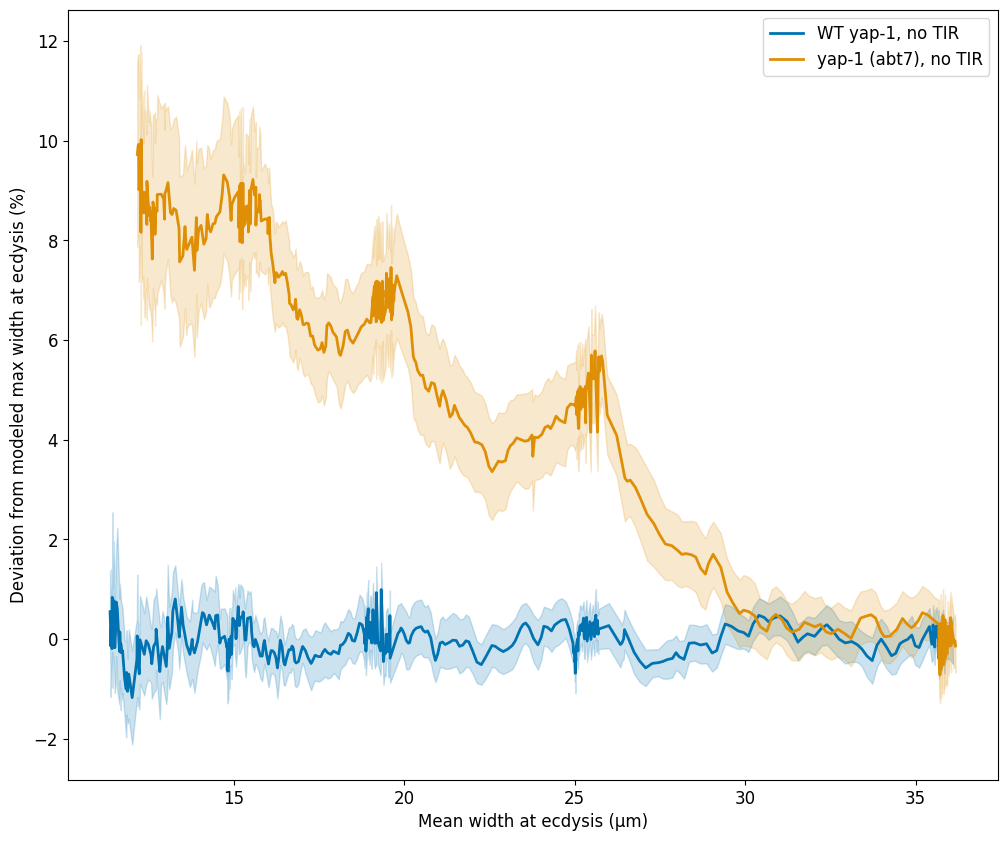

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
plot_deviation_from_model(conditions_struct, "body_seg_str_width_mean_rescaled", "body_seg_str_width_max_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Mean width at ecdysis (µm)', y_axis_label='Deviation from modeled max width at ecdysis (%)')

## yap-1 deletion makes body shape more heterogenious

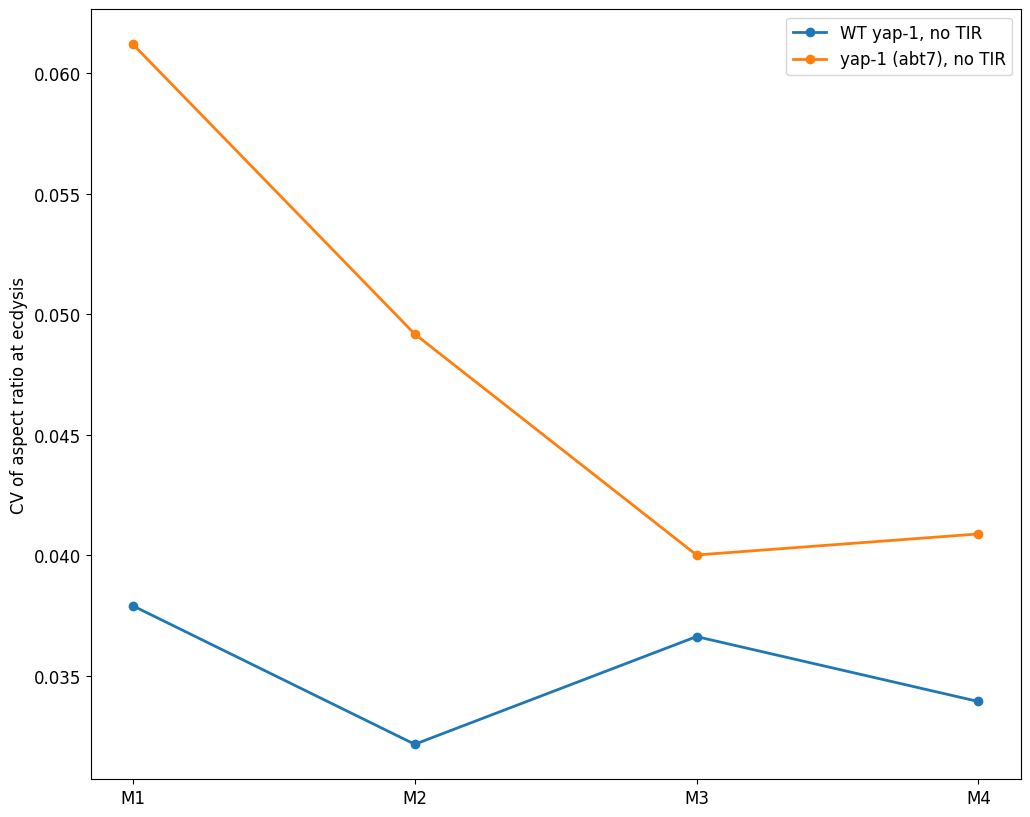

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_aspect_ratio_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of aspect ratio at ecdysis')   

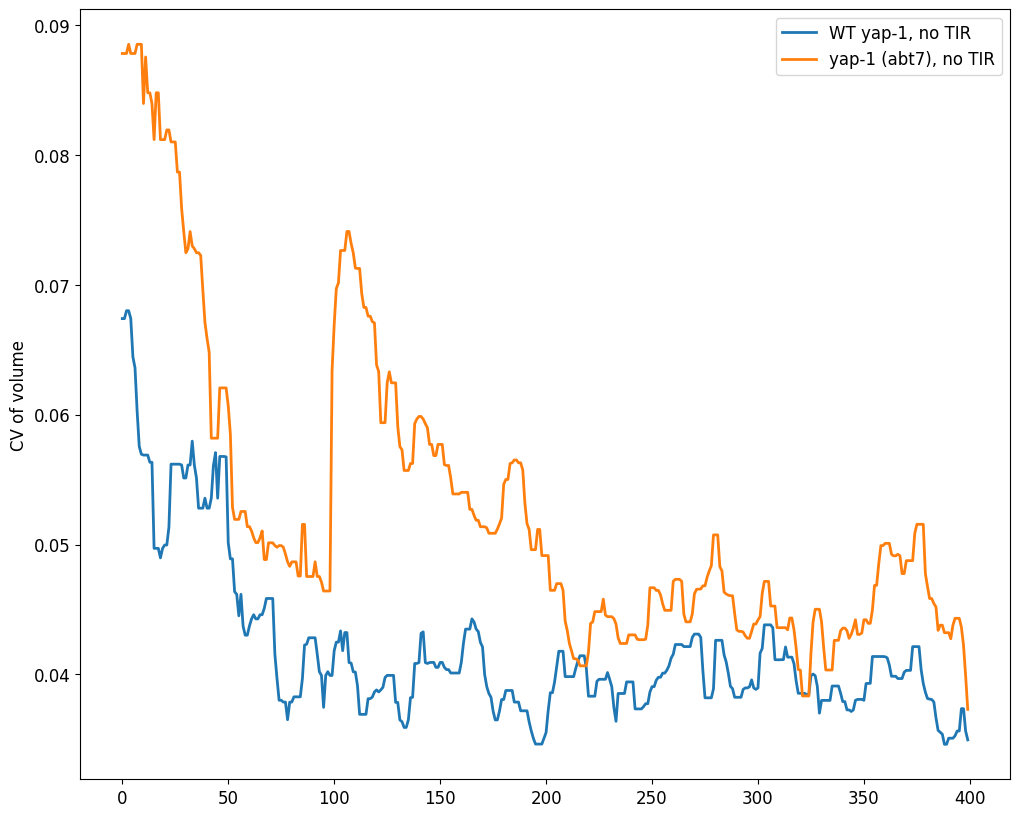

In [ ]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_aspect_ratio_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of volume') 

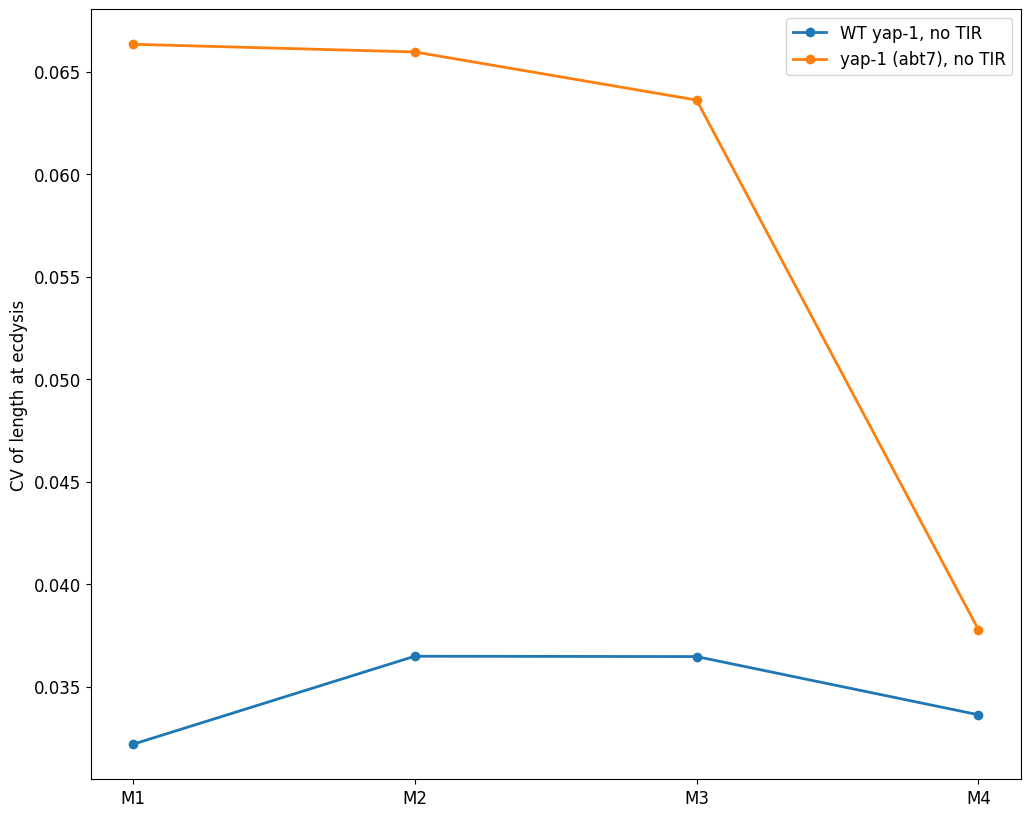

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of length at ecdysis')   

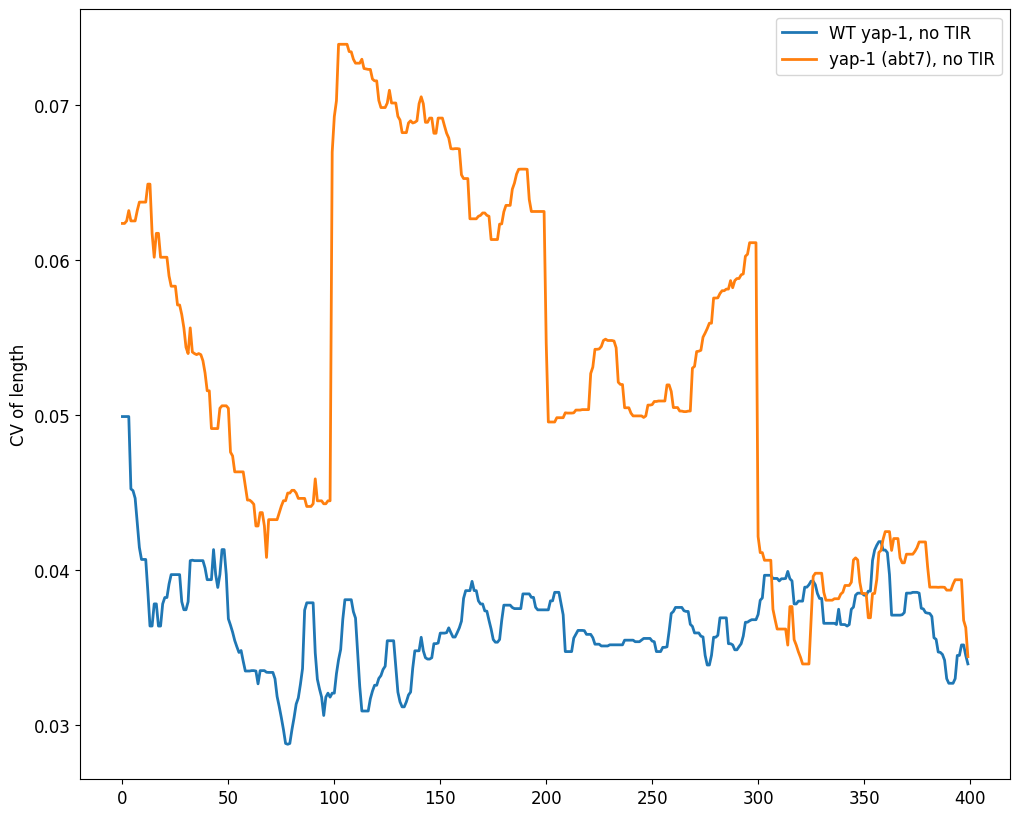

In [ ]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_length_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of length') 

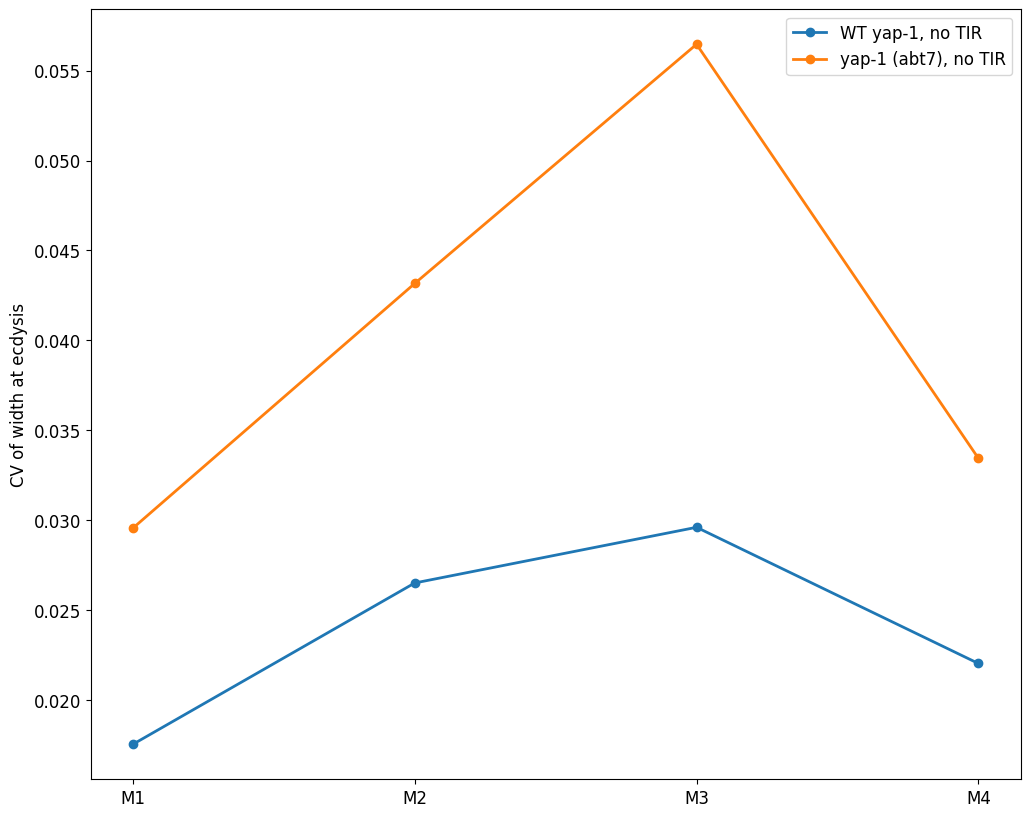

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_width_mean_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of width at ecdysis')   

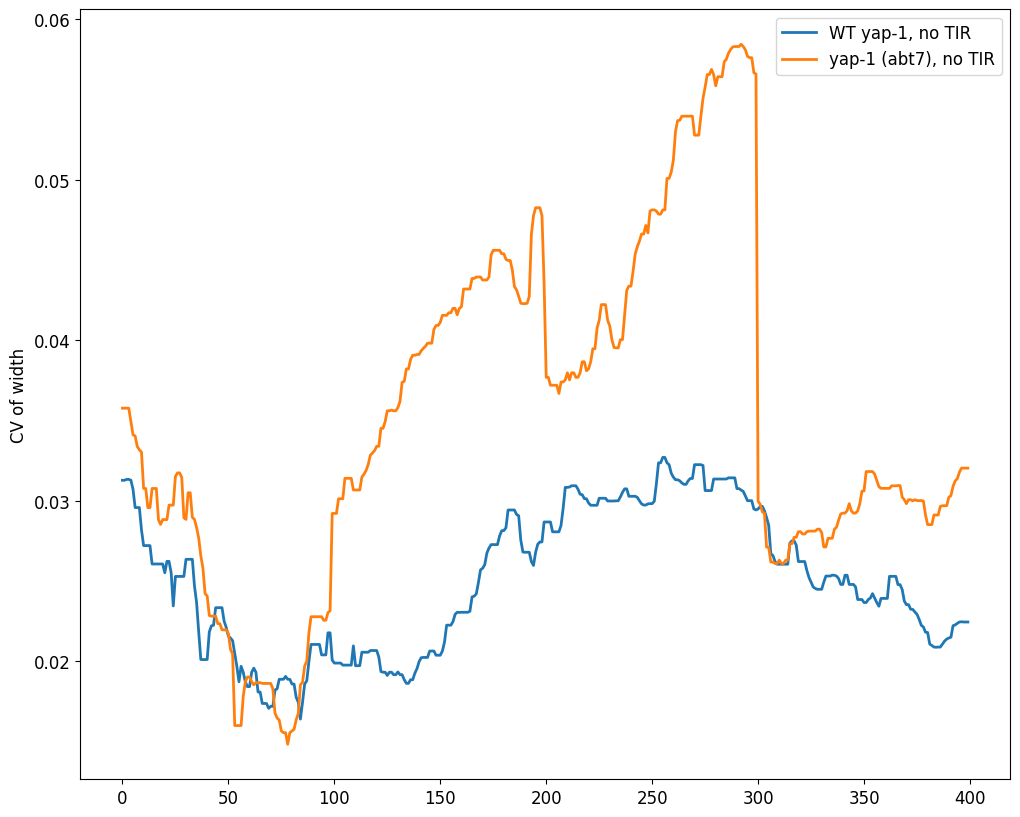

In [ ]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_width_mean_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of width')   

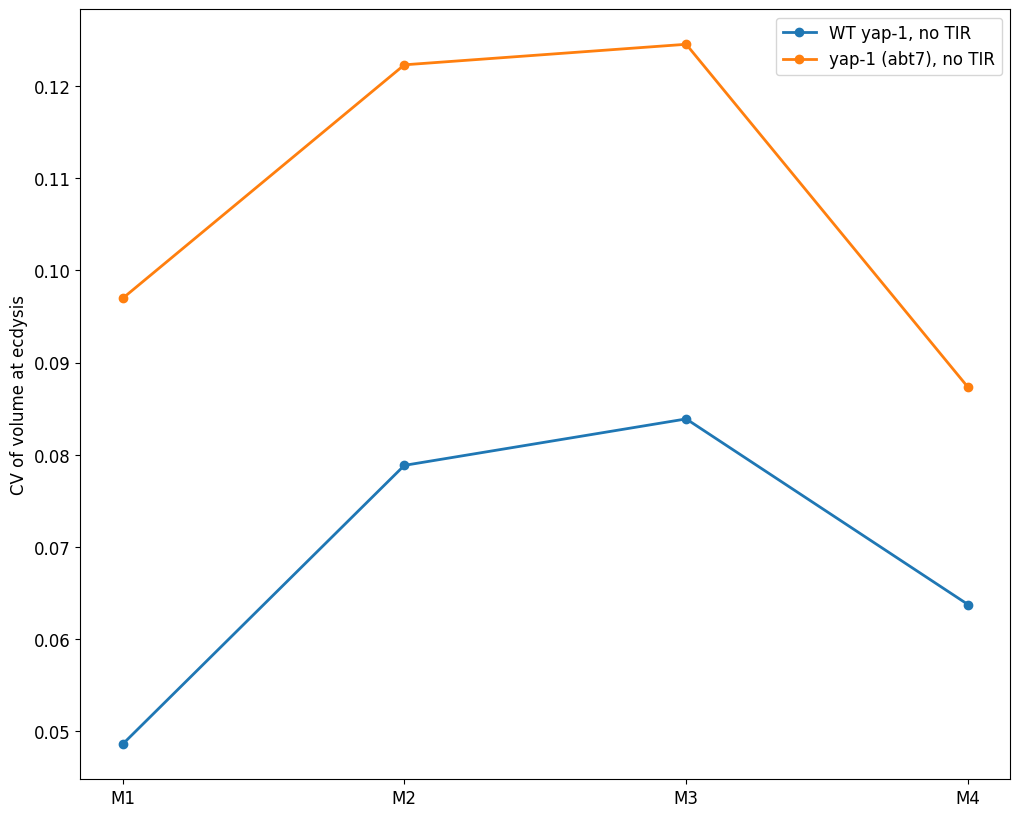

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of volume at ecdysis')   

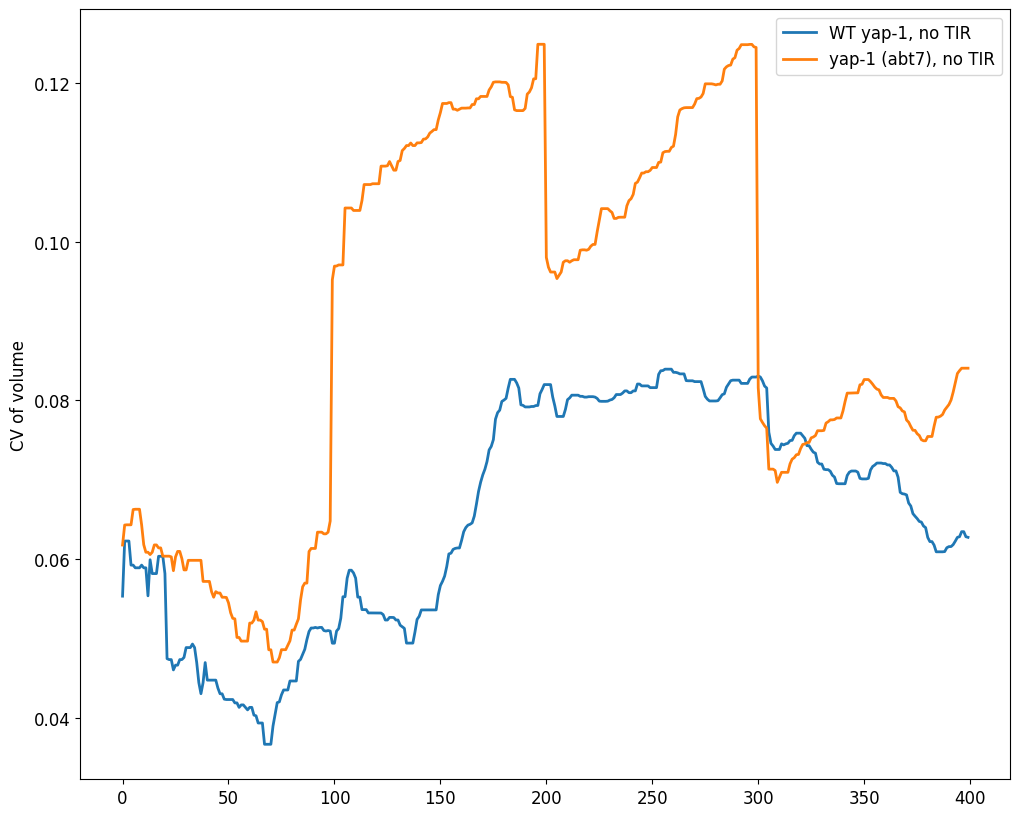

In [ ]:
plot_heterogeneity_rescaled_data(conditions_struct, 'body_seg_str_volume_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of volume') 

## yap-1 loss doesn’t affect pharynx/body volume proportions

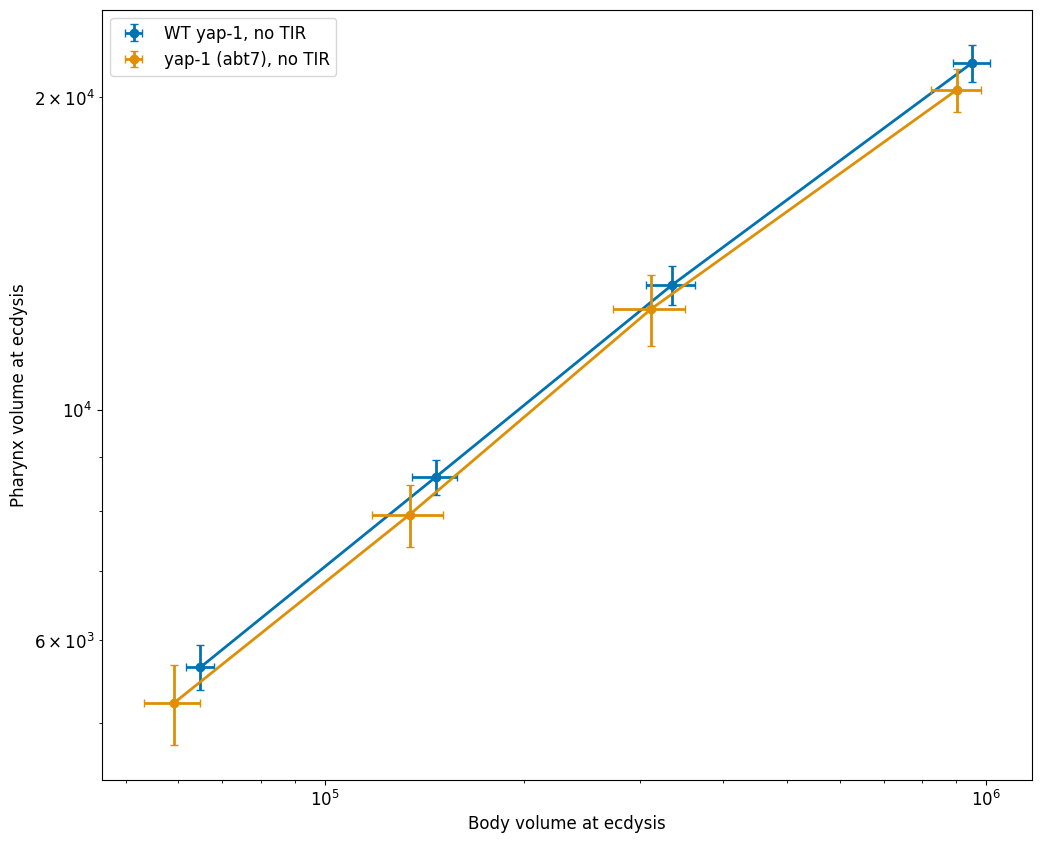

In [ ]:
conditions_to_plot = [0, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', 'pharynx_seg_str_volume_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, x_axis_label='Body volume at ecdysis', y_axis_label='Pharynx volume at ecdysis')

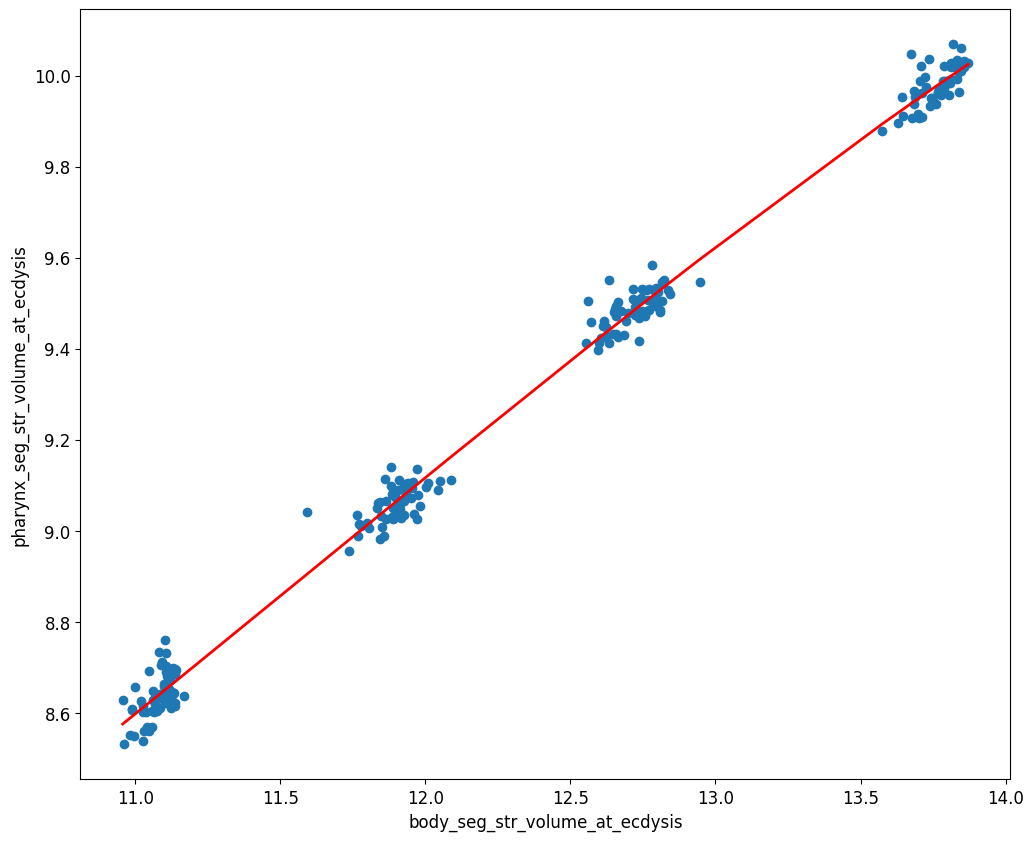

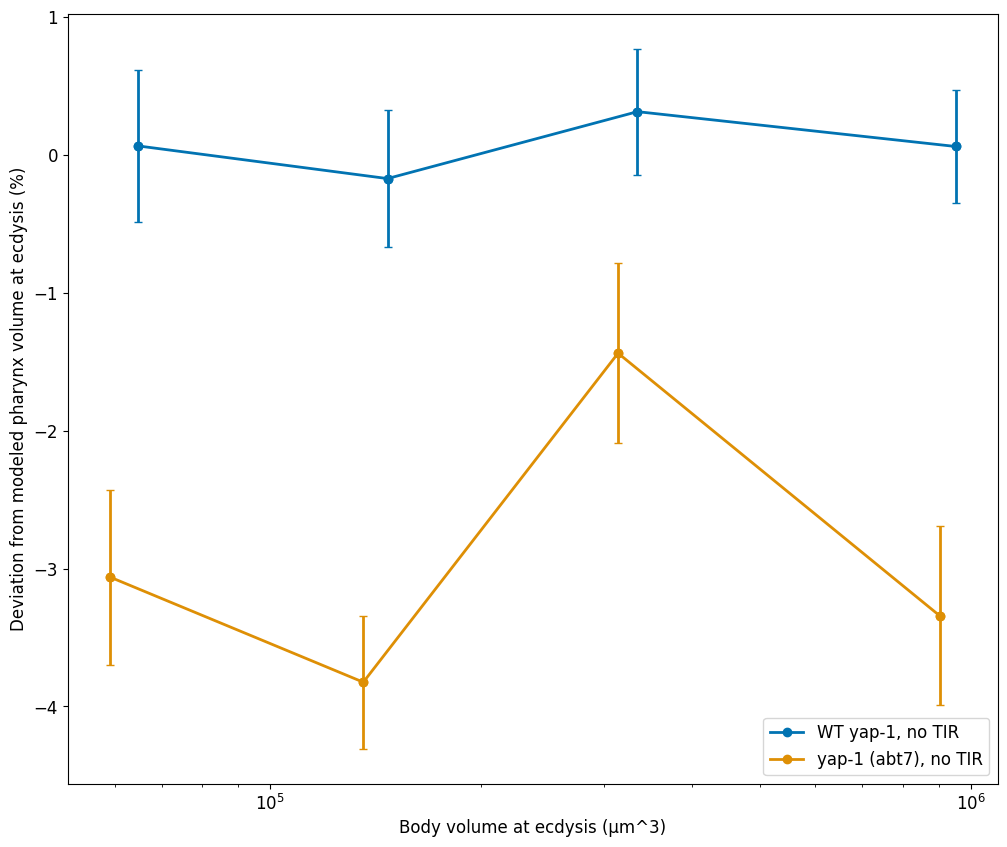

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, 'body_seg_str_volume_at_ecdysis', 'pharynx_seg_str_volume_at_ecdysis', control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Body volume at ecdysis (µm^3)', y_axis_label='Deviation from modeled pharynx volume at ecdysis (%)')

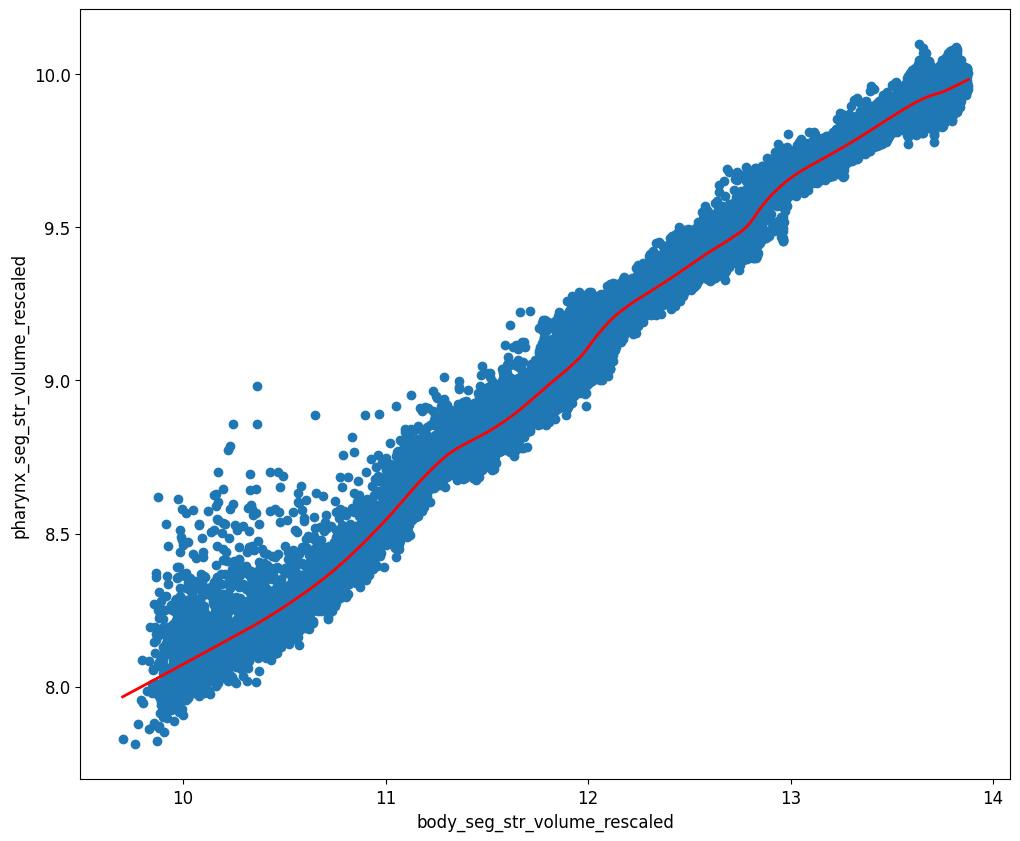

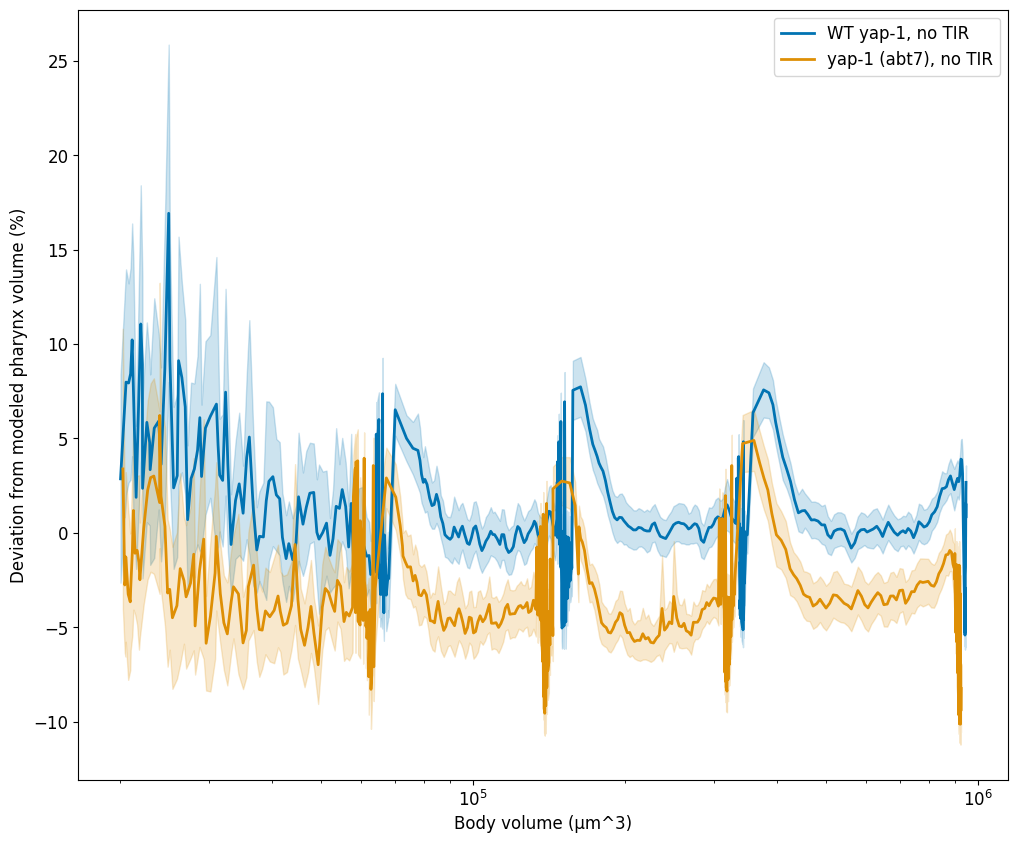

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0

plot_deviation_from_model(conditions_struct, "body_seg_str_volume_rescaled", "pharynx_seg_str_volume_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Body volume (µm^3)', y_axis_label='Deviation from modeled pharynx volume (%)')

## yap-1 loss makes pharynxes too short for their respective body length

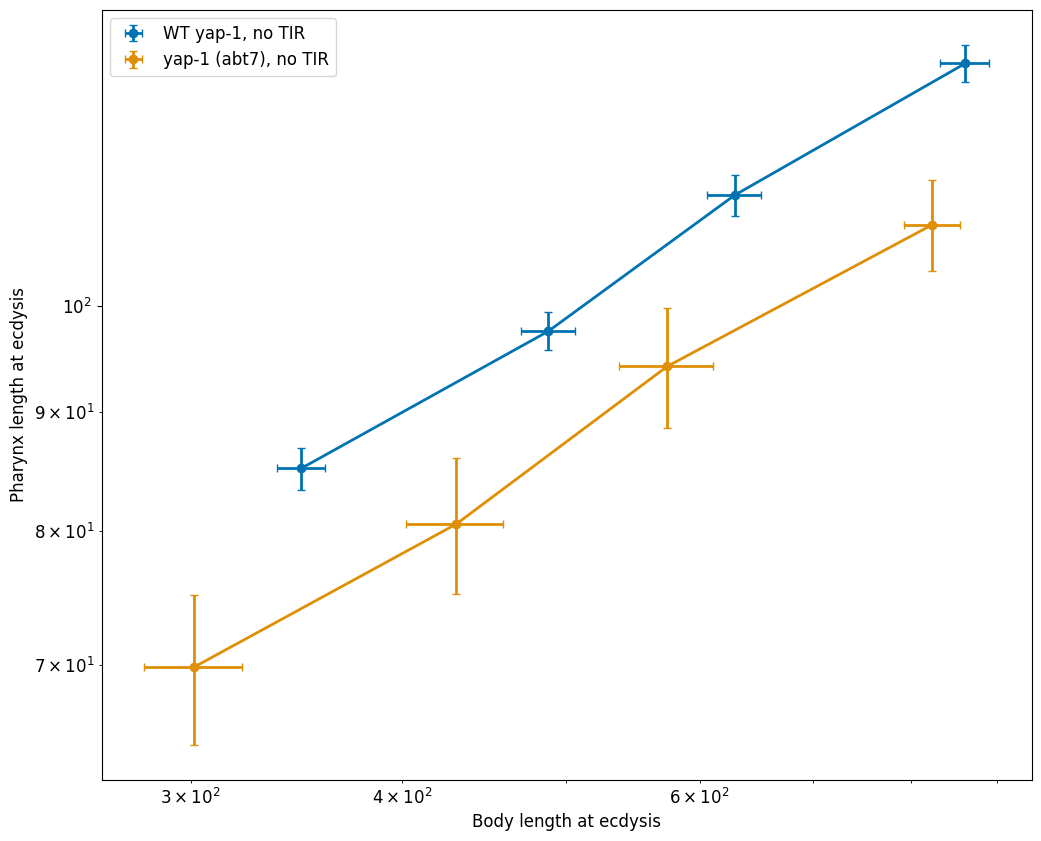

In [ ]:
conditions_to_plot = [0, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, x_axis_label='Body length at ecdysis', y_axis_label='Pharynx length at ecdysis')

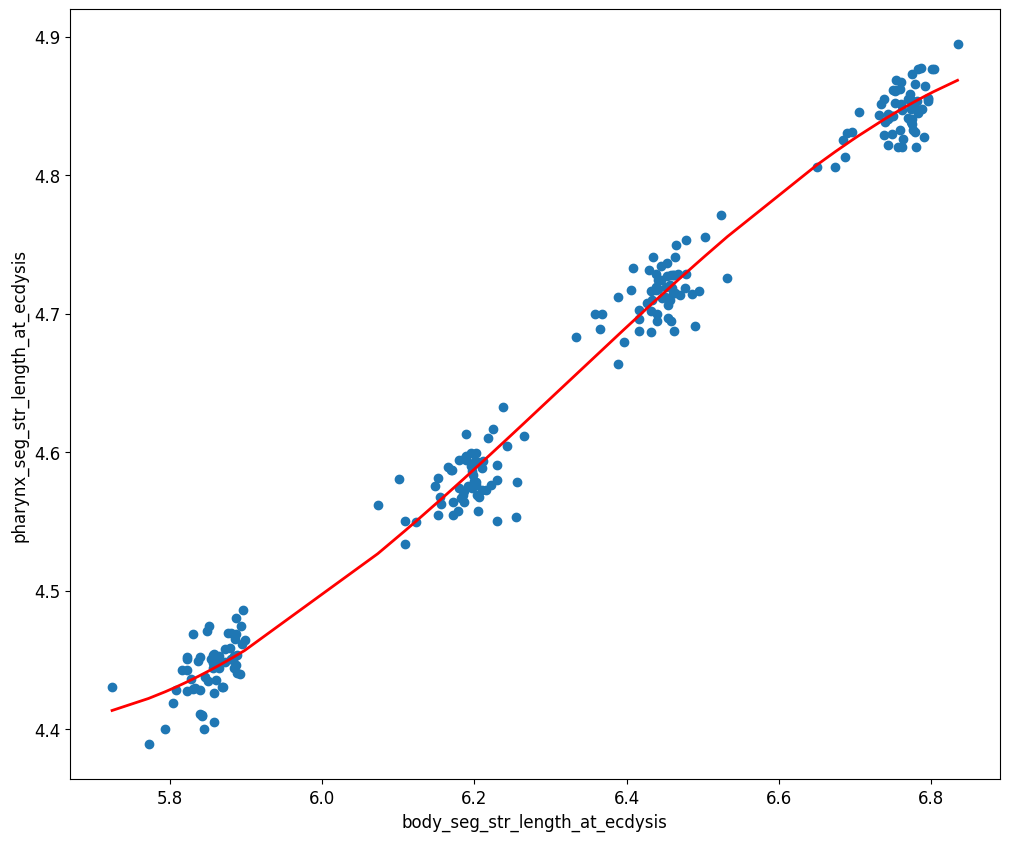

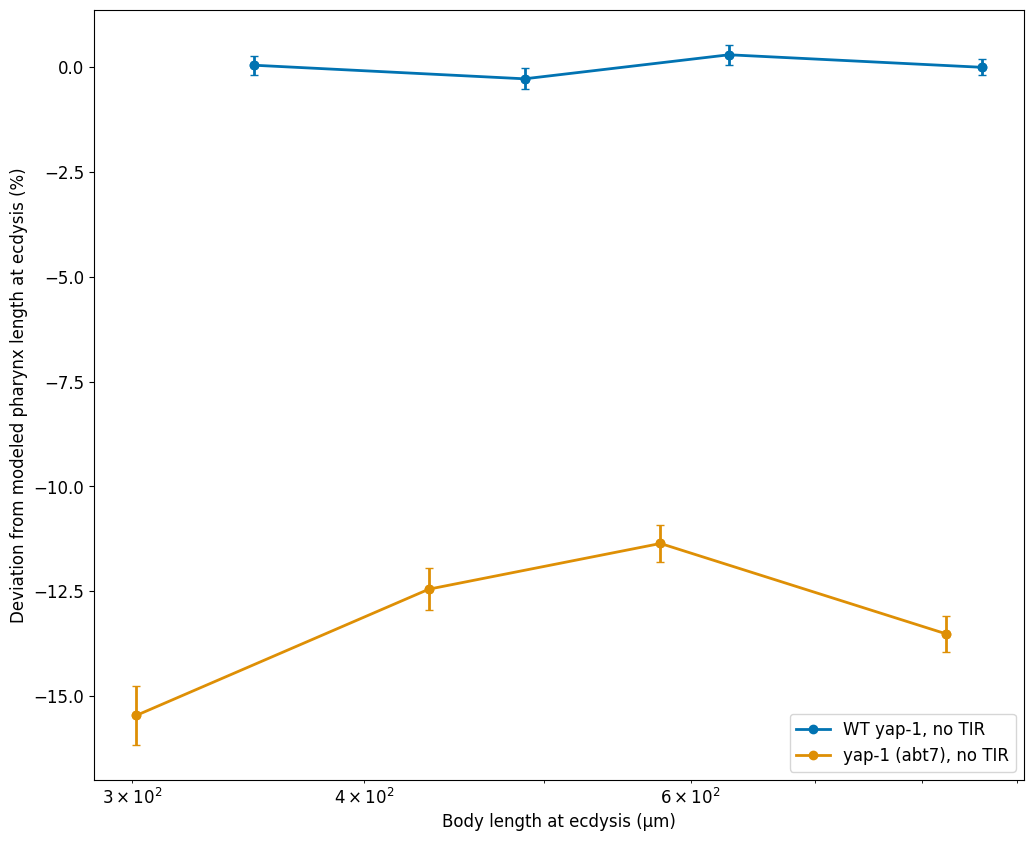

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, 'body_seg_str_length_at_ecdysis', 'pharynx_seg_str_length_at_ecdysis', control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Body length at ecdysis (µm)', y_axis_label='Deviation from modeled pharynx length at ecdysis (%)')

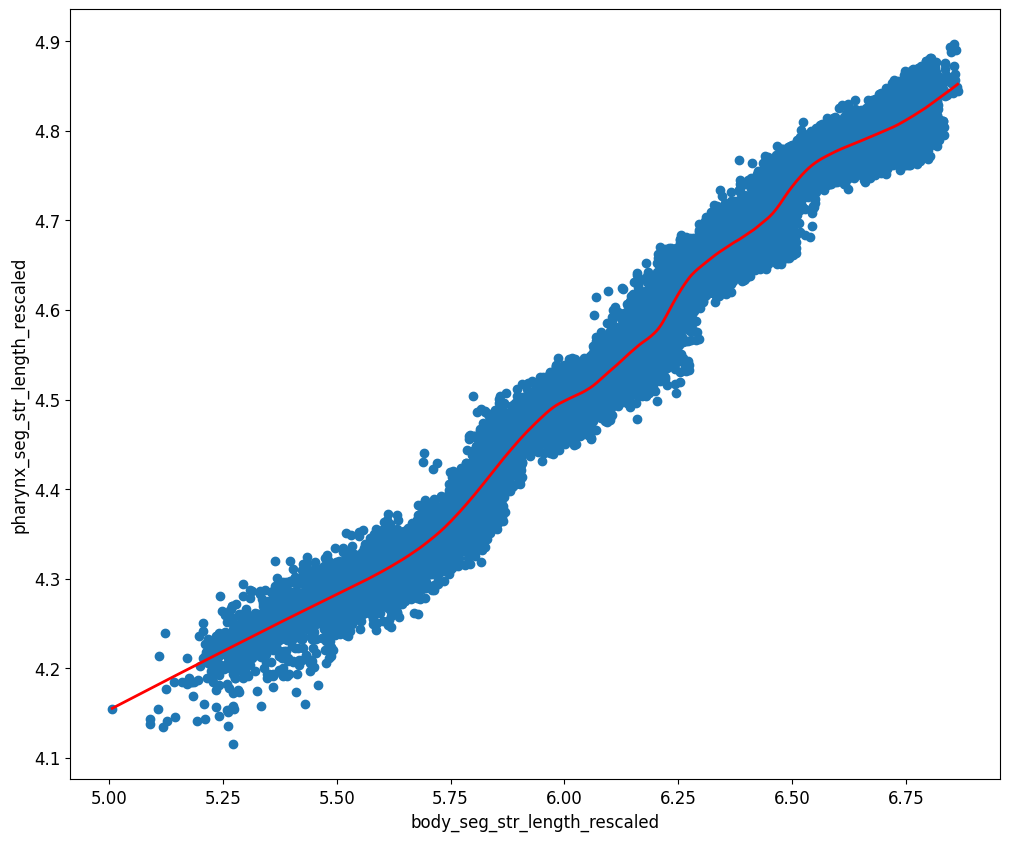

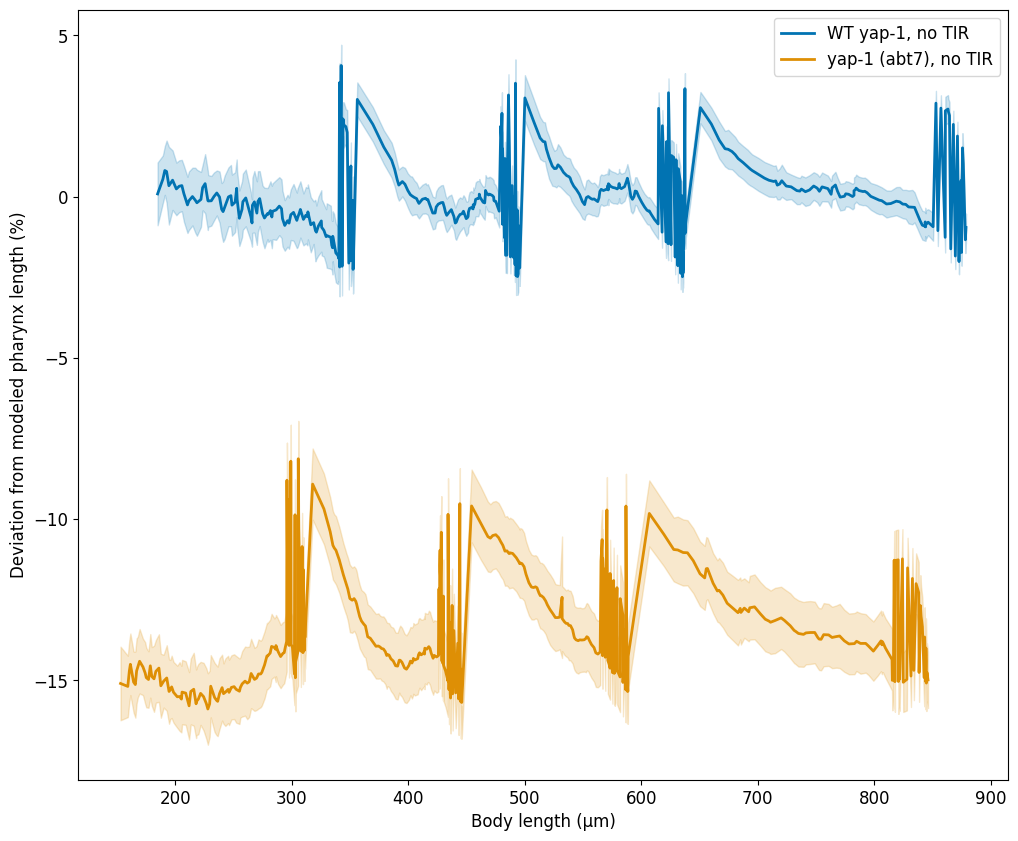

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0

plot_deviation_from_model(conditions_struct, "body_seg_str_length_rescaled", "pharynx_seg_str_length_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Body length (µm)', y_axis_label='Deviation from modeled pharynx length (%)')

## yap-1 loss makes pharynxes dumpy

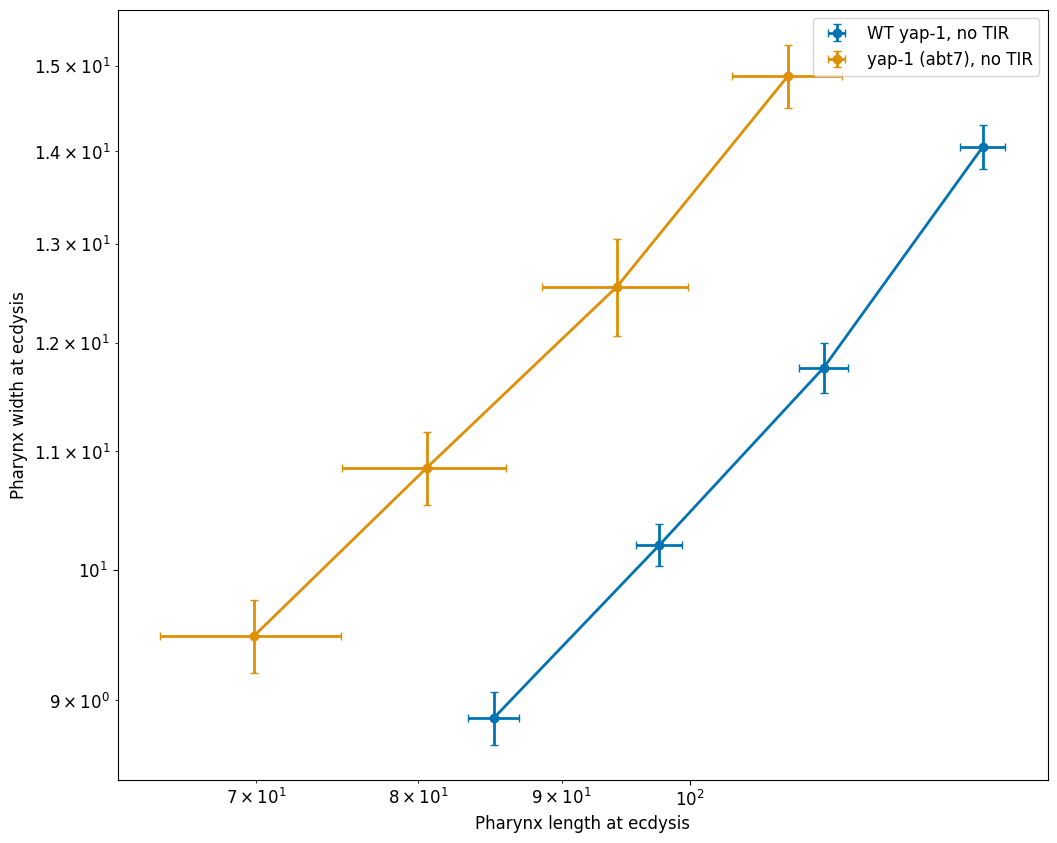

In [ ]:
conditions_to_plot = [0, 4]
colors = None


plot_correlation_at_ecdysis(conditions_struct, 'pharynx_seg_str_length_at_ecdysis', 'pharynx_seg_str_width_mean_at_ecdysis', conditions_to_plot, colors=colors, log_scale = (True, True), legend = {'description': ''}, x_axis_label='Pharynx length at ecdysis', y_axis_label='Pharynx width at ecdysis')

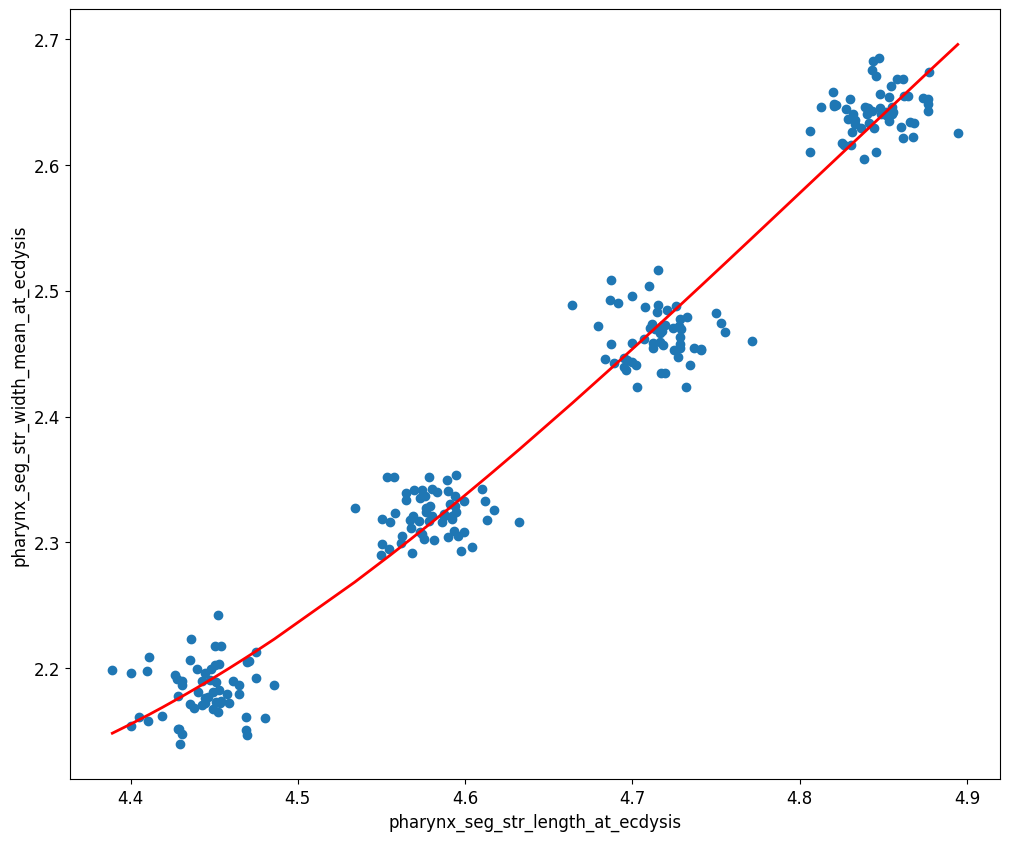

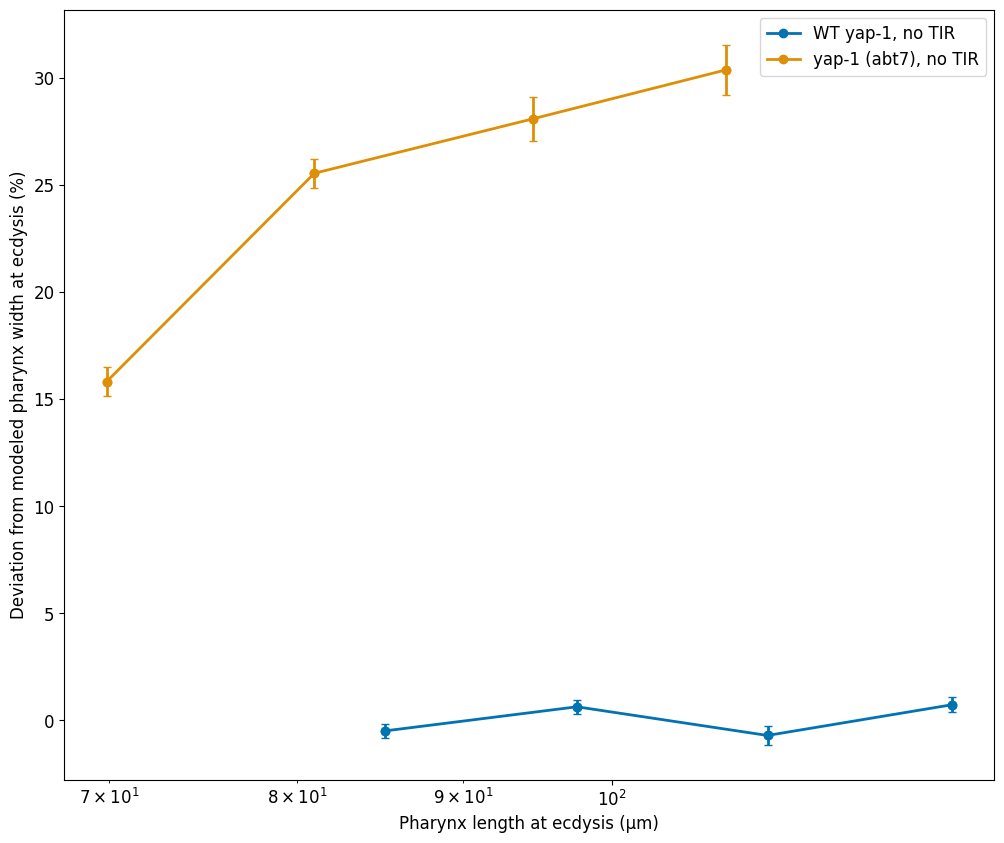

In [ ]:
conditions_to_plot = [0, 4]
control_condition = 0
colors = None

plot_deviation_from_model_at_ecdysis(conditions_struct, 'pharynx_seg_str_length_at_ecdysis', 'pharynx_seg_str_width_mean_at_ecdysis', control_condition, conditions_to_plot, colors=colors, remove_hatch=True, exclude_arrests = True, log_scale = (True, False), legend = {'description': ''}, x_axis_label='Pharynx length at ecdysis (µm)', y_axis_label='Deviation from modeled pharynx width at ecdysis (%)')

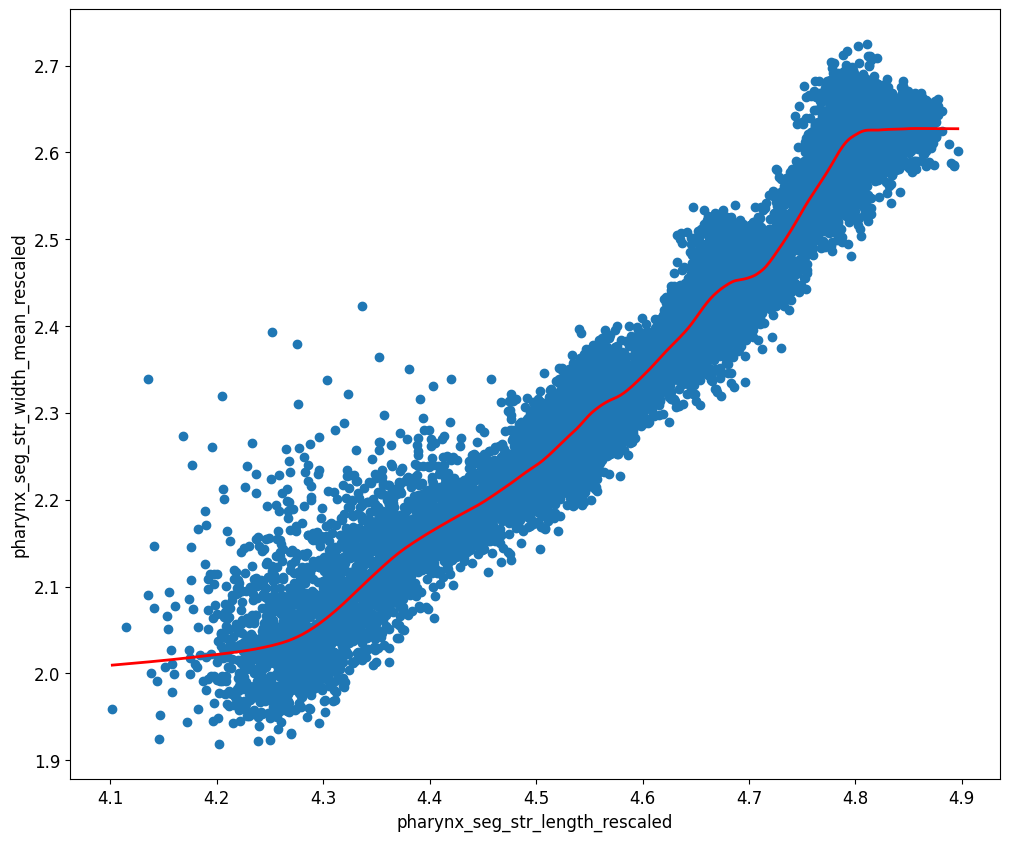

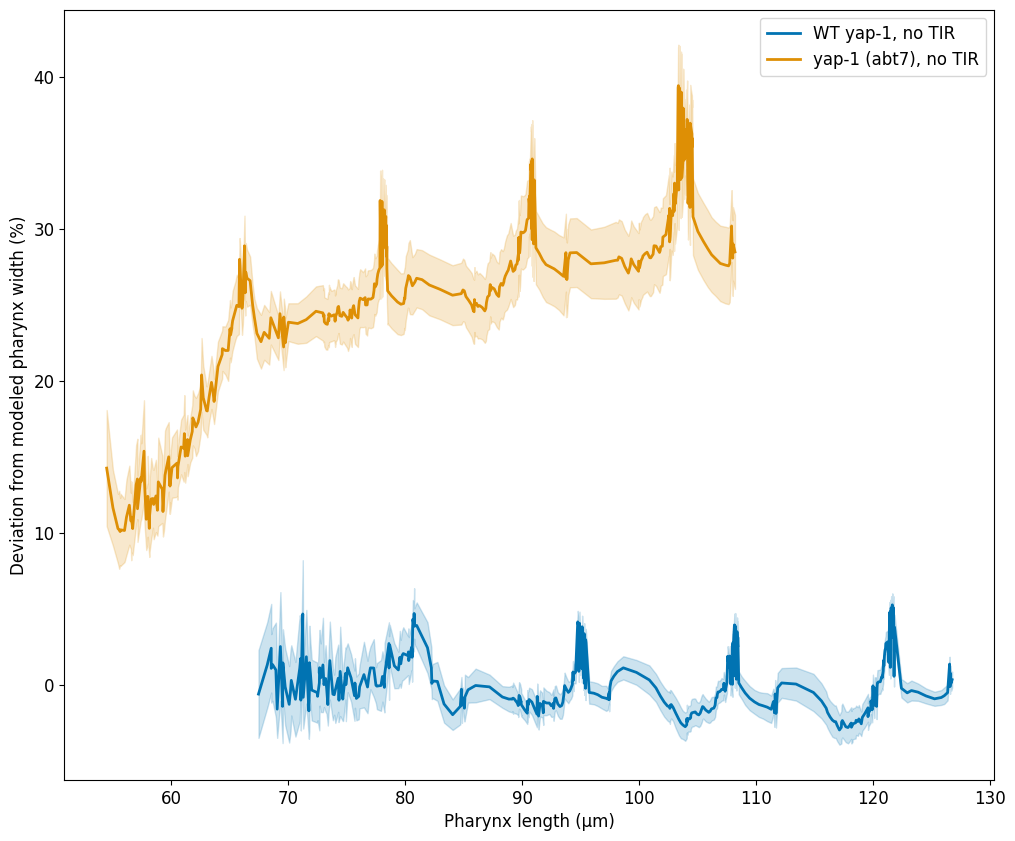

In [ ]:
conditions_to_plot = [0, 4]
plot_deviation_from_model(conditions_struct, "pharynx_seg_str_length_rescaled", "pharynx_seg_str_width_mean_rescaled", control_condition, conditions_to_plot, colors=colors, log_scale = False, legend = {'description': ''}, x_axis_label='Pharynx length (µm)', y_axis_label='Deviation from modeled pharynx width (%)')

## yap-1 deletion makes pharynx shape more heterogenious

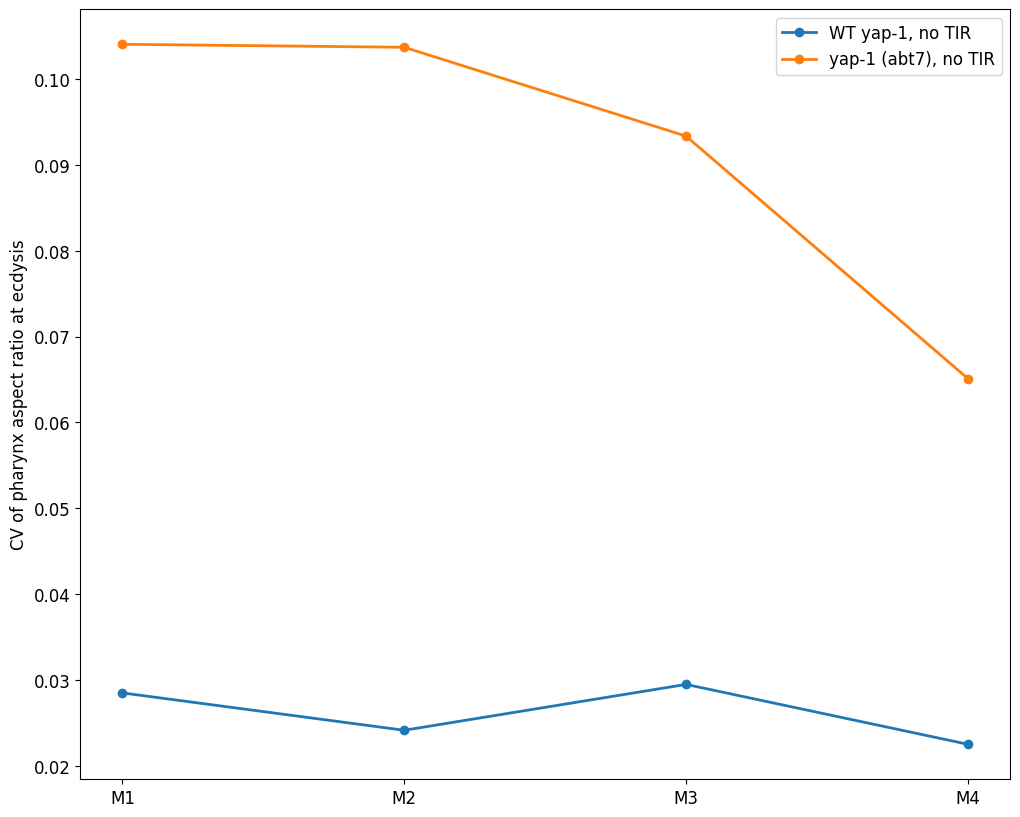

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'pharynx_seg_str_aspect_ratio_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx aspect ratio at ecdysis')   

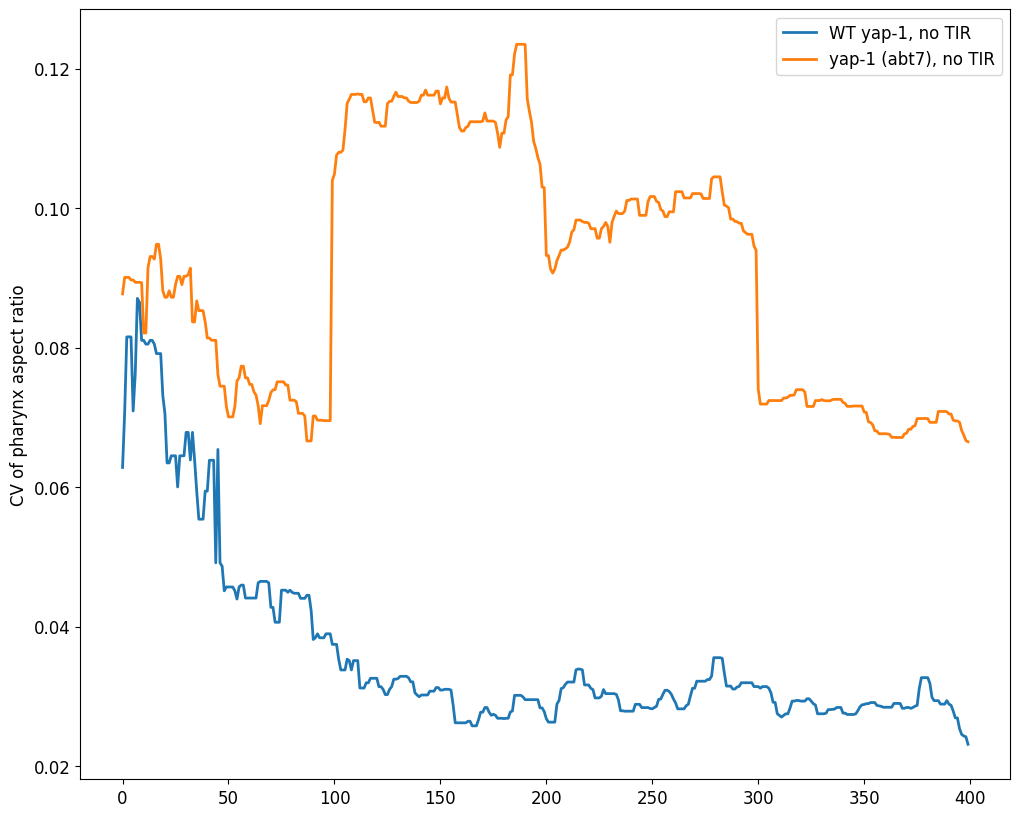

In [ ]:
plot_heterogeneity_rescaled_data(conditions_struct, 'pharynx_seg_str_aspect_ratio_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx aspect ratio') 

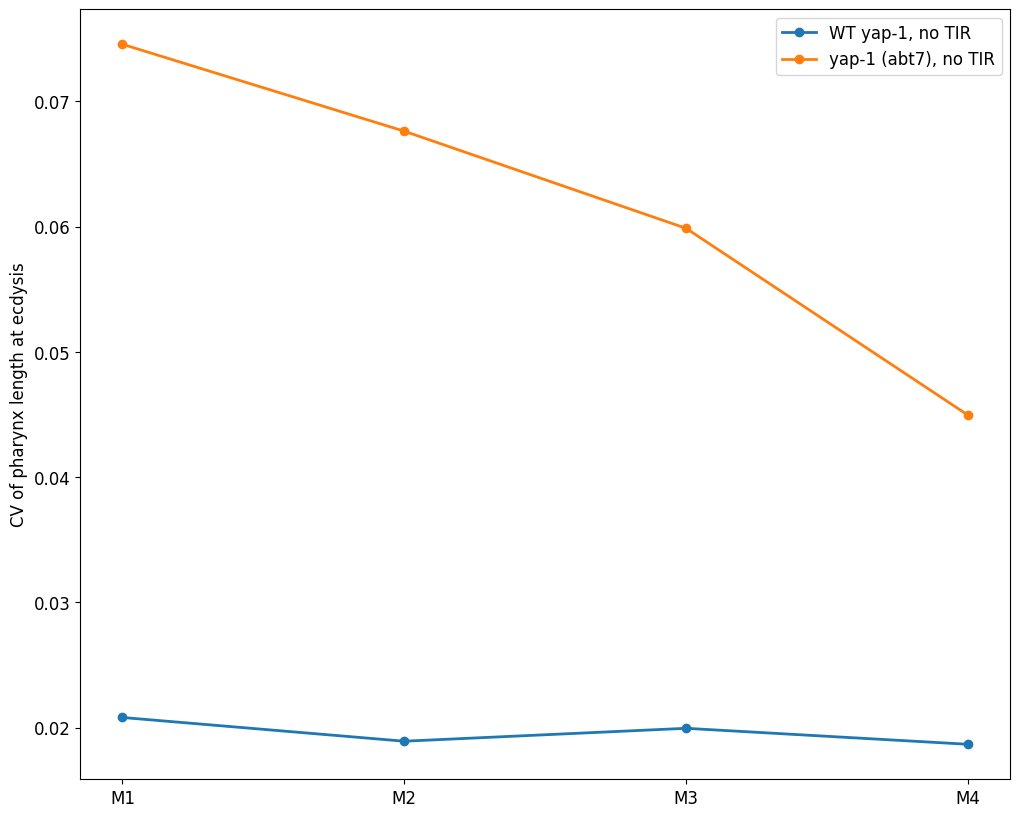

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'pharynx_seg_str_length_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx length at ecdysis')   

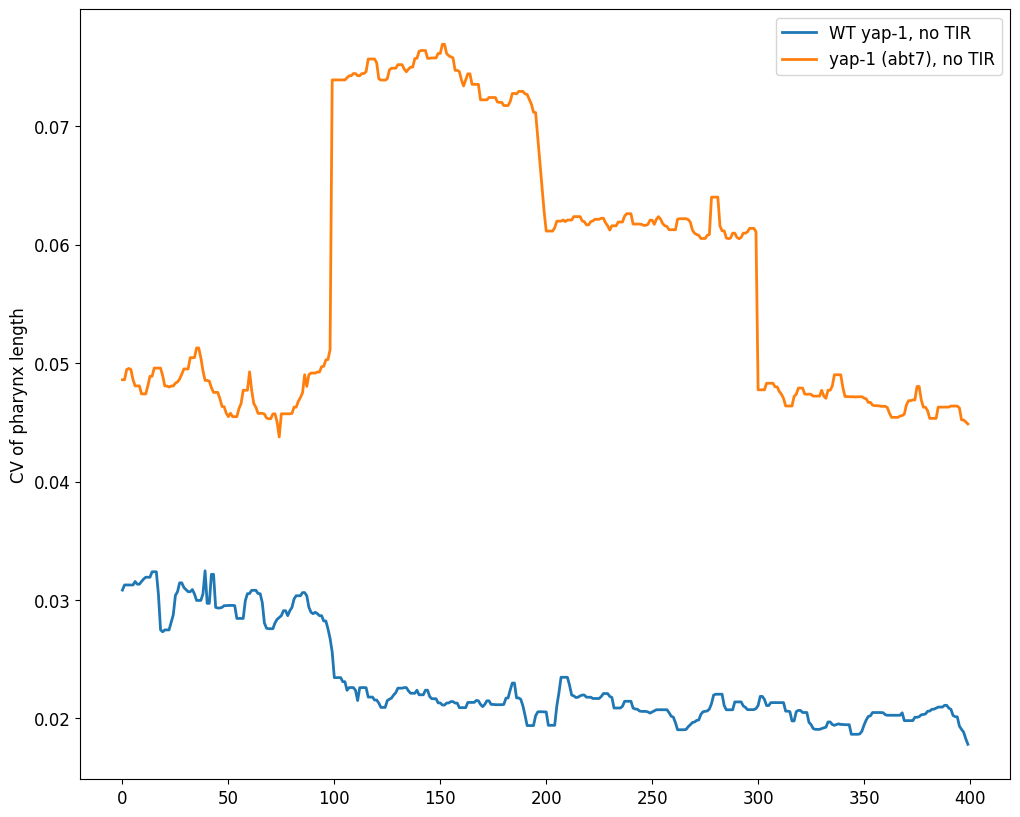

In [ ]:
plot_heterogeneity_rescaled_data(conditions_struct, 'pharynx_seg_str_length_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx length') 

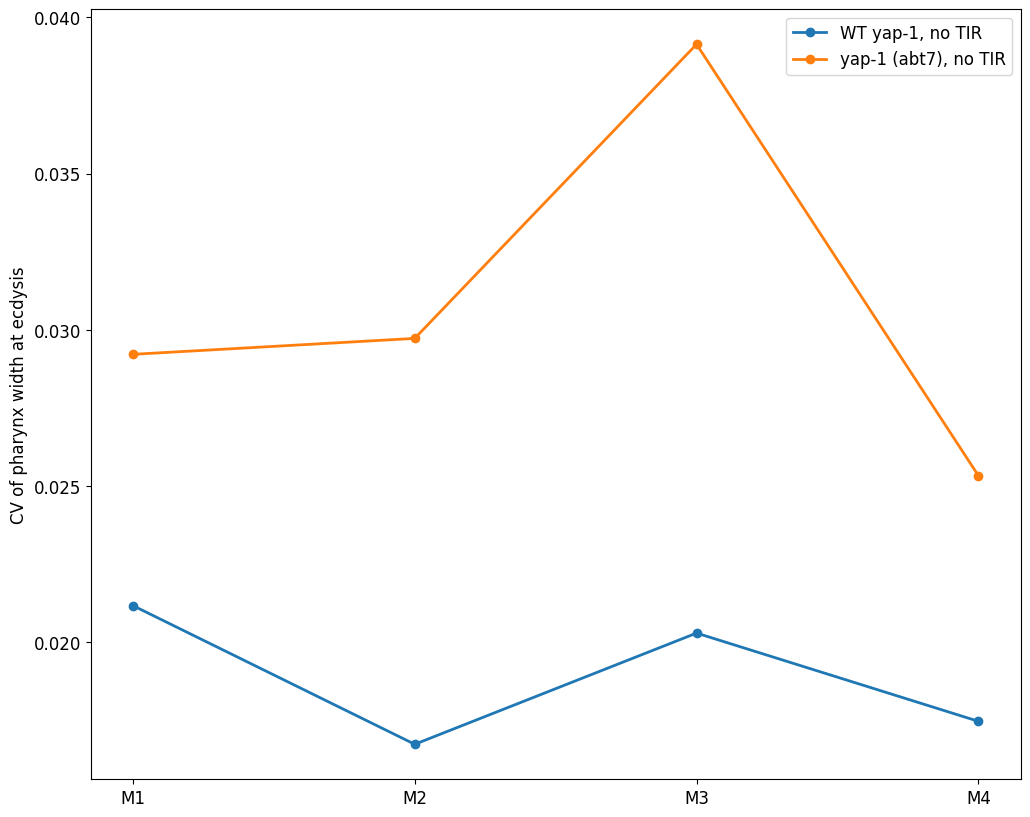

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'pharynx_seg_str_width_mean_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx width at ecdysis')   

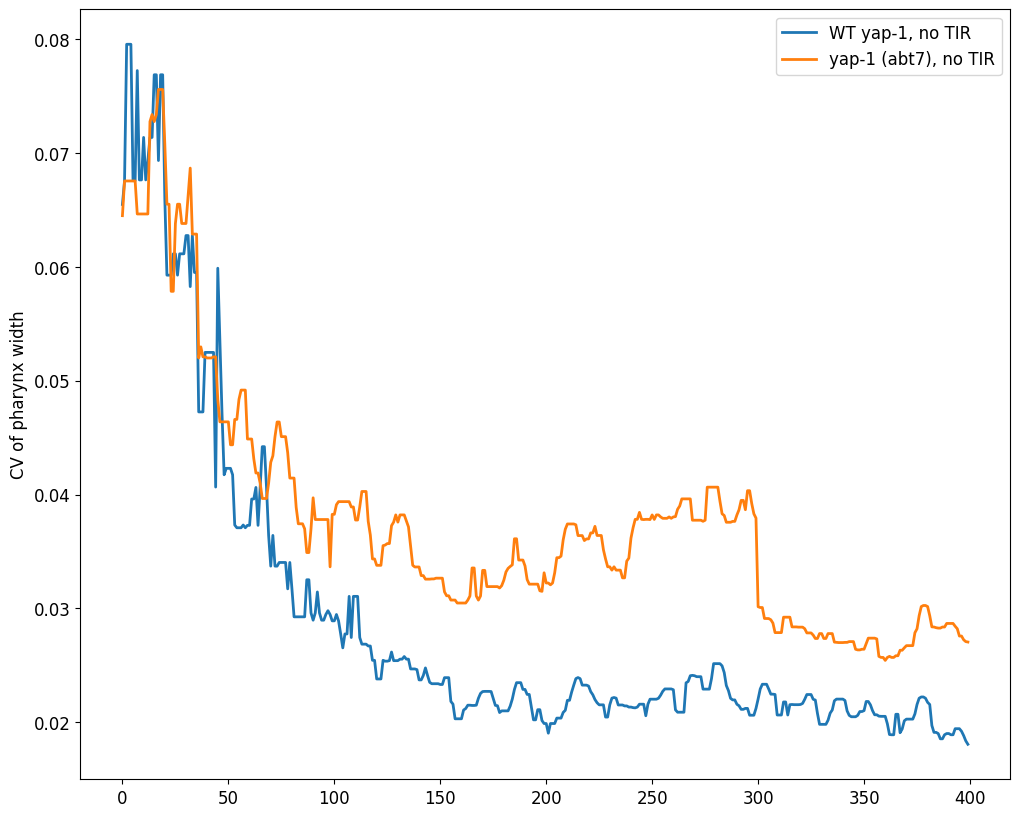

In [ ]:
plot_heterogeneity_rescaled_data(conditions_struct, 'pharynx_seg_str_width_mean_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx width') 

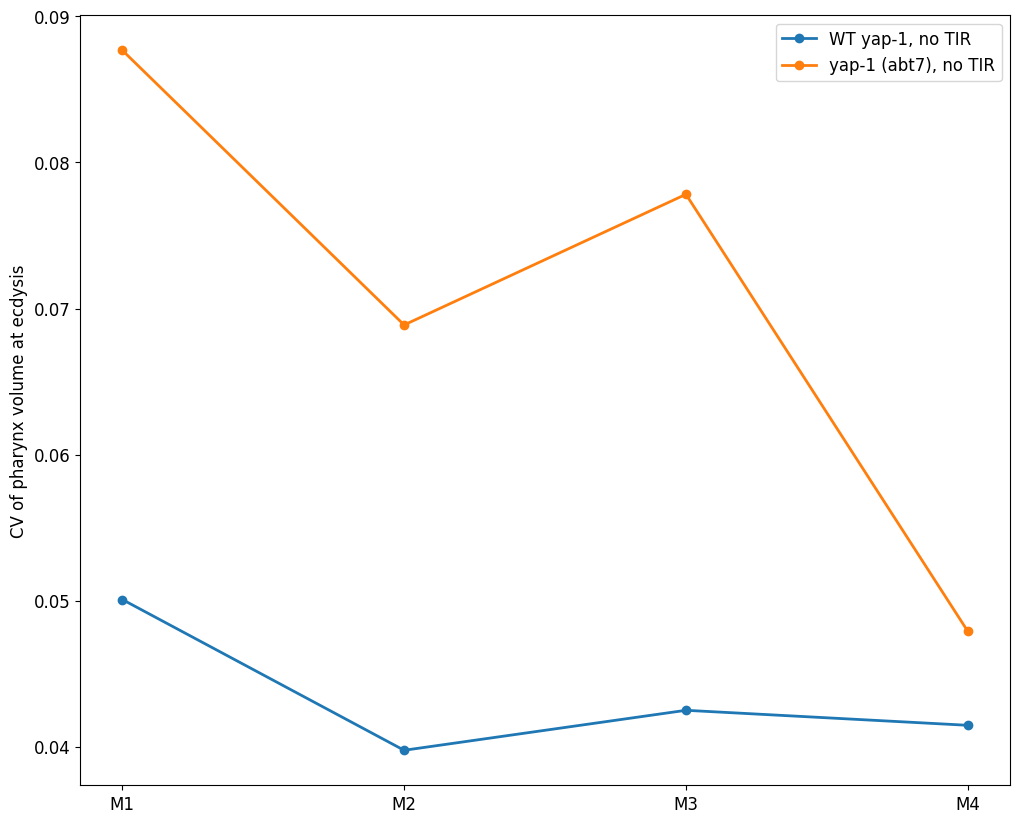

In [ ]:
plot_heterogeneity_at_ecdysis(conditions_struct, 'pharynx_seg_str_volume_at_ecdysis', [0, 4], legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx volume at ecdysis')   

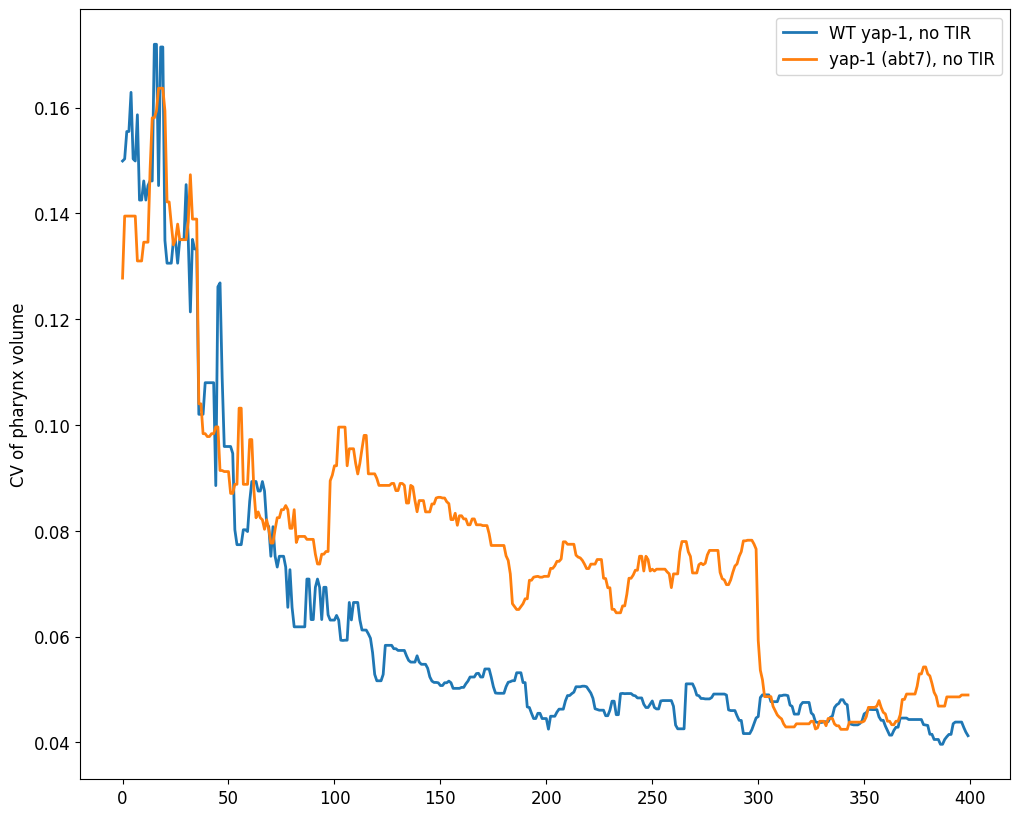

In [ ]:
plot_heterogeneity_rescaled_data(conditions_struct, 'pharynx_seg_str_volume_rescaled', [0, 4], smooth = True, legend = {'description': ''}, exclude_arrests = False, y_axis_label='CV of pharynx volume') 

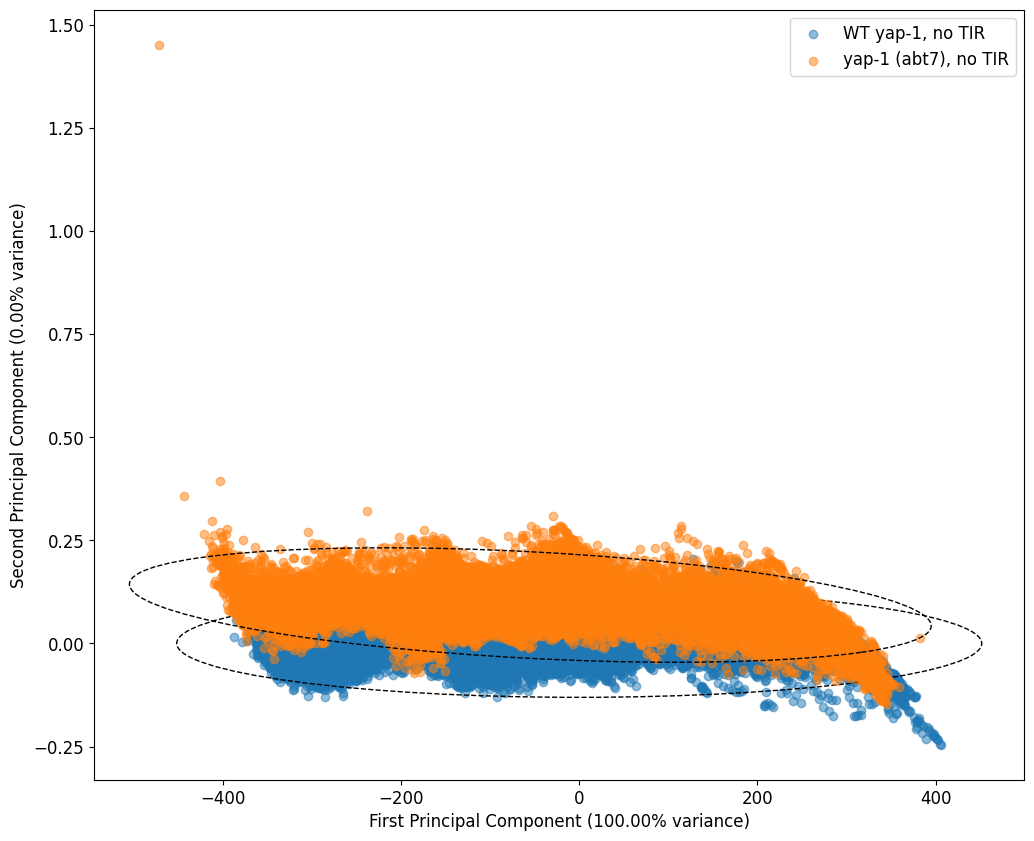

In [ ]:
from typing import Dict, List
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from sklearn.preprocessing import StandardScaler

def confidence_ellipse(x, y, ax, n_std=2.5, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The Axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plot_pca_two_series(
    conditions_struct: Dict,
    column_one: str,
    column_two: str,
    conditions_to_plot: List[int], 
    control_condition: int = 0,
    remove_hatch = True, 
    legend = None, 
    x_axis_label = None, 
    y_axis_label = None, 
    exclude_arrests: bool = False,):

    fig, ax = plt.subplots()

    pca = PCA()
    series_one_control = conditions_struct[control_condition][column_one].flatten()
    series_two_control = conditions_struct[control_condition][column_two].flatten()

    # remove nans
    nan_indices = np.isnan(series_one_control) | np.isnan(series_two_control)
    series_one_control = series_one_control[~nan_indices]
    series_two_control = series_two_control[~nan_indices]

    X = np.stack([series_one_control, series_two_control], axis=1)
    pca.fit(X)

    for condition in conditions_to_plot:
        condition_dict = conditions_struct[condition]

        series_one = condition_dict[column_one].flatten()
        series_two = condition_dict[column_two].flatten()

        # remove nans
        nan_indices = np.isnan(series_one) | np.isnan(series_two)
        series_one = series_one[~nan_indices]
        series_two = series_two[~nan_indices]

        X = np.stack([series_one, series_two], axis=1)
        X_pca = pca.transform(X)

        ax.scatter(X_pca[:, 0], X_pca[:, 1], label=condition_dict['description'], alpha=0.5)
        # ax.scatter(X[:, 0], X[:, 1], label=condition_dict['description'], alpha=0.5)

        # Add confidence ellipses
        confidence_ellipse(X_pca[:, 0], X_pca[:, 1], ax, edgecolor='black', linestyle='dashed')


    plt.legend()
    # Add plot labels and legend
    if x_axis_label:
        plt.xlabel(x_axis_label)
    else:
        plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
    
    if y_axis_label:
        plt.ylabel(y_axis_label)
    else:
        plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.show()

plot_pca_two_series(conditions_struct, 'body_seg_str_length_rescaled', 'body_seg_str_log_width_mean_rescaled', [0, 4])

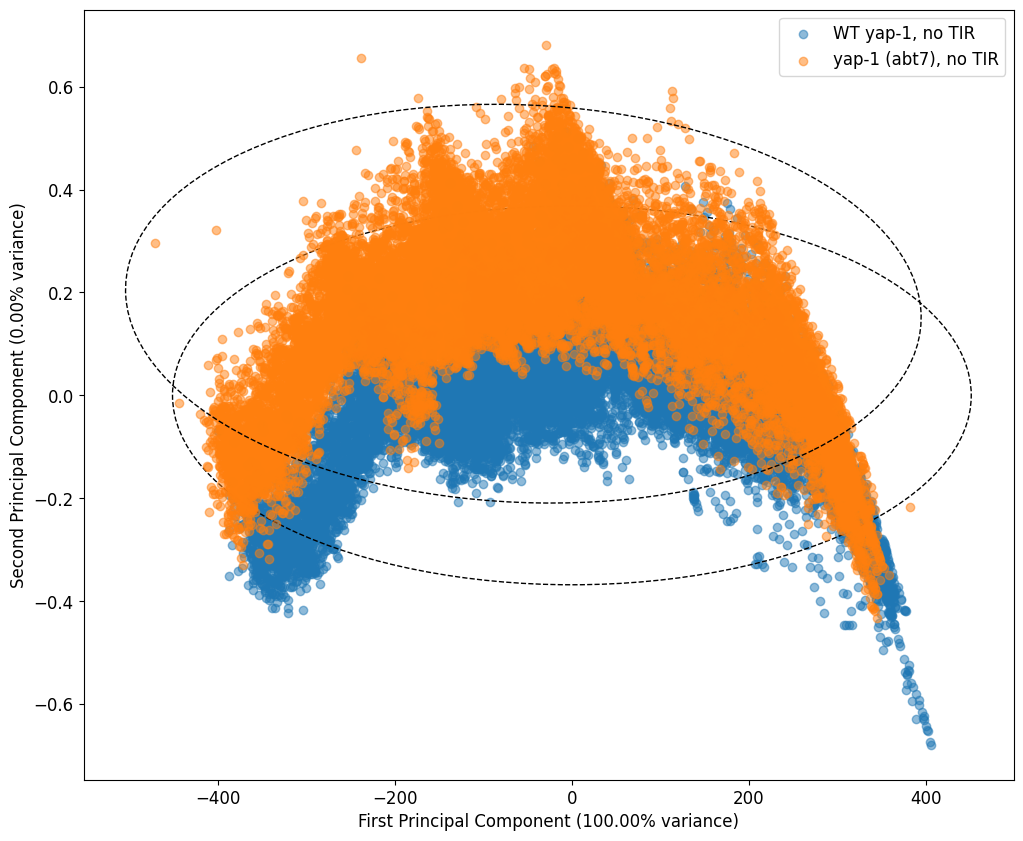

In [ ]:
plot_pca_two_series(conditions_struct, 'body_seg_str_length_rescaled', 'body_seg_str_log_volume_rescaled', [0, 4])

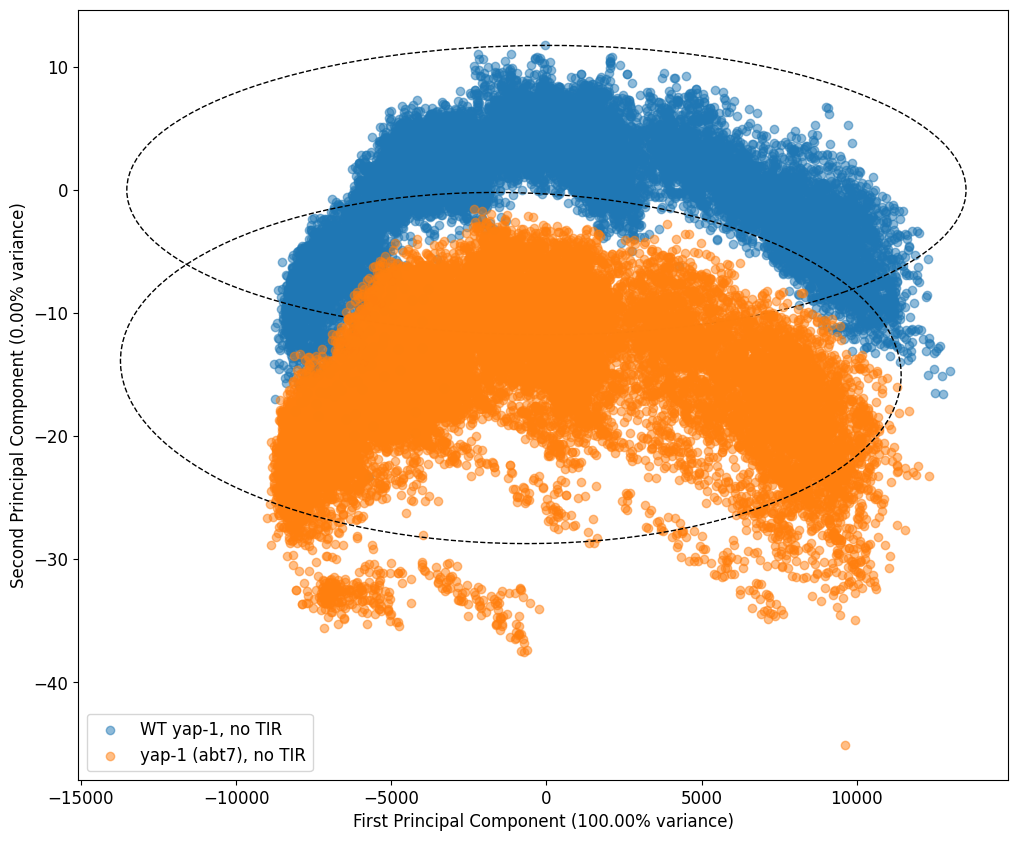

In [ ]:
plot_pca_two_series(conditions_struct, 'pharynx_seg_str_length_rescaled', 'pharynx_seg_str_volume_rescaled', [0, 4])

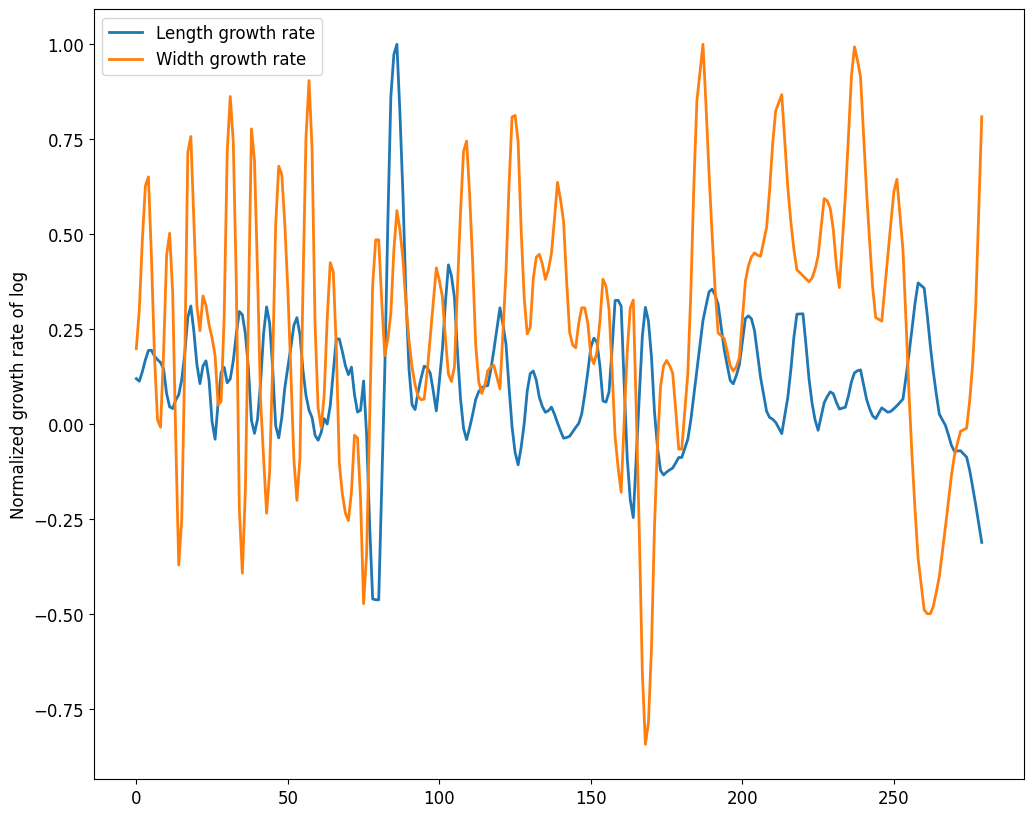

In [ ]:
from scipy import signal

idx = 40
s = conditions_struct[0]['body_seg_str_log_length_growth_rate_rescaled'][idx][20:300]
l = conditions_struct[0]['body_seg_str_log_width_mean_growth_rate_rescaled'][idx][20:300]

plt.plot(s/np.max(s))
plt.plot(l/np.max(l))
plt.legend(['Length growth rate', 'Width growth rate'])
plt.ylabel('Normalized growth rate of log')
plt.show()

In [ ]:
import numpy
import matplotlib.pyplot as plt
from scipy.signal import correlate
from numpy.linalg import norm
from scipy.stats import spearmanr, pearsonr


def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else numpy.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return numpy.array(corr)

def plot_autocorrelation(conditions_struct, series_name, conditions_to_plot, lags,
    colors=None,
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
):
    if colors is None:
        color_palette = sns.color_palette("colorblind", len(conditions_to_plot))
    else:
        color_palette = colors

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        series = condition[series_name]

        # valid_indices = np.r_[10:70, 110:170, 210:270, 310:370]
        # # set non valid indices to nan
        # series = series[:, valid_indices]

        autocorr = []

        for j in range(series.shape[0]):
            autocorr.append(autocorr1(series[j], lags))
        
        autocorr = np.array(autocorr)

        autocorr_mean = np.nanmean(autocorr, axis=0)
        autocorr_std = np.nanstd(autocorr, axis=0)
        autocorr_ste = autocorr_std / np.sqrt(autocorr.shape[0])

        label = build_legend(condition, legend)

        plt.fill_between(lags, autocorr_mean - 1.96 * autocorr_ste, autocorr_mean + 1.96 * autocorr_ste, alpha=0.5, color=color_palette[i])
        plt.plot(lags, autocorr_mean, label=label, color=color_palette[i])

    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

def plot_cross_correlation(conditions_struct, series_one_name, series_two_name, conditions_to_plot,
    colors=None,
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
    mode='same',
    normalize=True,
    aggregate=False,
):
    if colors is None:
        color_palette = sns.color_palette("colorblind", len(conditions_to_plot))
    else:
        color_palette = colors

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        series_one = condition[series_one_name]
        series_two = condition[series_two_name]

        label = build_legend(condition, legend)

        if aggregate:
            aggregated_series_one = np.nanmean(series_one, axis=0)
            aggregated_series_two = np.nanmean(series_two, axis=0)

            if normalize:
                N = len(aggregated_series_one)
                normalized_aggregated_series_one = aggregated_series_one / np.nanstd(aggregated_series_one)
                normalized_aggregated_series_two = aggregated_series_two / np.nanstd(aggregated_series_two)

                cross_corr = correlate(normalized_aggregated_series_one, normalized_aggregated_series_two, mode=mode) / N

            else:
                cross_corr = correlate(aggregated_series_one, aggregated_series_two, mode=mode)

            if mode == 'full':
                lags = np.arange(-cross_corr.shape[0] // 2, cross_corr.shape[0] // 2)
            else:  # mode == 'same'
                lags = np.arange(-(cross_corr.shape[0] // 2), cross_corr.shape[0] // 2)
            plt.plot(lags, cross_corr, color=color_palette[i], label=label)

        else:
            cross_corr = []
            for j in range(series_one.shape[0]):
                if normalize:
                    N = len(series_one[j])

                    normalized_series_one = series_one[j]/np.nanstd(series_one[j])
                    normalized_series_two = series_two[j]/np.nanstd(series_two[j])
                    cross_correlation = signal.correlate(normalized_series_one, normalized_series_two, mode=mode) / N

                    cross_corr.append(cross_correlation)
                else:
                    cross_corr.append(signal.correlate(series_one[j], series_two[j], mode=mode))

            cross_corr = np.array(cross_corr)
            cross_corr_mean = np.nanmean(cross_corr, axis=0)
            cross_corr_std = np.nanstd(cross_corr, axis=0)

            nan_indices = np.isnan(cross_corr).any(axis=1)
            print(np.sum(nan_indices))
            ste_denominator = np.sqrt(np.sum(~nan_indices))
            cross_corr_ste = cross_corr_std / ste_denominator

            # Calculate proper x-axis values
            if mode == 'full':
                lags = np.arange(-cross_corr_mean.shape[0] // 2, cross_corr_mean.shape[0] // 2)
            else:  # mode == 'same'
                lags = np.arange(-(cross_corr_mean.shape[0] // 2), cross_corr_mean.shape[0] // 2)

            plt.fill_between(lags,cross_corr_mean - 1.96 * cross_corr_ste, cross_corr_mean + 1.96 * cross_corr_ste, alpha=0.5, color=color_palette[i])
            plt.plot(lags,cross_corr_mean, label=label, color=color_palette[i])

    # add a vertical line at 0
    plt.axvline(x=0, color='black', linestyle='--', alpha = 0.5)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

def plot_spearman_correlation(
    conditions_struct,
    series_one_name,
    series_two_name,
    conditions_to_plot,
    colors=None,
    legend=None,
    x_axis_label=None,
    y_axis_label=None,
    log_scale=False,
):
    if colors is None:
        color_palette = sns.color_palette("colorblind", len(conditions_to_plot))
    else:
        color_palette = colors

    for i, condition_id in enumerate(conditions_to_plot):
        condition = conditions_struct[condition_id]
        series_one = condition[series_one_name]
        series_two = condition[series_two_name]

        corr = []
        
        for j in range(series_one.shape[0]):
            # select slice of series_one and series_two, from 0 to 80, 110 to 180, 210 to 280, 310 to 380
            selected_indices = np.r_[10:70, 110:170, 210:270, 310:370]
            # selected_indices = np.r_[80:100, 180:200, 280:300, 380:400]
            selected_series_one = series_one[j][selected_indices]
            selected_series_two = series_two[j][selected_indices]

            # selected_series_one = series_one[j]
            # selected_series_two = series_two[j]

            corr.append(spearmanr(selected_series_one, selected_series_two)[0])
 
        selected_indices = np.r_[20:70, 120:170, 220:270, 320:370]

        series_one_values = np.array(series_one)
        series_two_values = np.array(series_two)

        # remove nans
        nan_indices = np.isnan(series_one_values).any(axis=1) | np.isnan(series_two_values).any(axis=1)
        series_one_values = series_one_values[~nan_indices]
        series_two_values = series_two_values[~nan_indices]

        series_one_values = series_one_values[:, selected_indices]
        series_two_values = series_two_values[:, selected_indices]

        series_one_values = series_one_values.flatten()
        series_two_values = series_two_values.flatten()

        # linear regression
        x = series_one_values
        y = series_two_values
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        results = model.fit()
        # plt.scatter(series_one_values, series_two_values, color=color_palette[i], alpha=0.5)
        # plt.plot(series_one_values, results.params[0] + results.params[1] * series_one_values, color=color_palette[i], label=f"y = {results.params[0]:.2f} + {results.params[1]:.2f}x")
        # plt.show()

        corr = np.array(corr)
        corr_mean = np.nanmean(corr)
        corr_std = np.nanstd(corr)
        corr_ste = corr_std / np.sqrt(corr.shape[0])

        label = build_legend(condition, legend)

        plt.errorbar(i, corr_mean, yerr=1.96 * corr_ste, fmt='o', color=color_palette[i], label=label)

    plt.xticks(range(len(conditions_to_plot)), [conditions_struct[i]['description'] for i in conditions_to_plot], rotation=45)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend()
    plt.show()

28
68


/home/spsalmon/micromamba/envs/towbintools/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


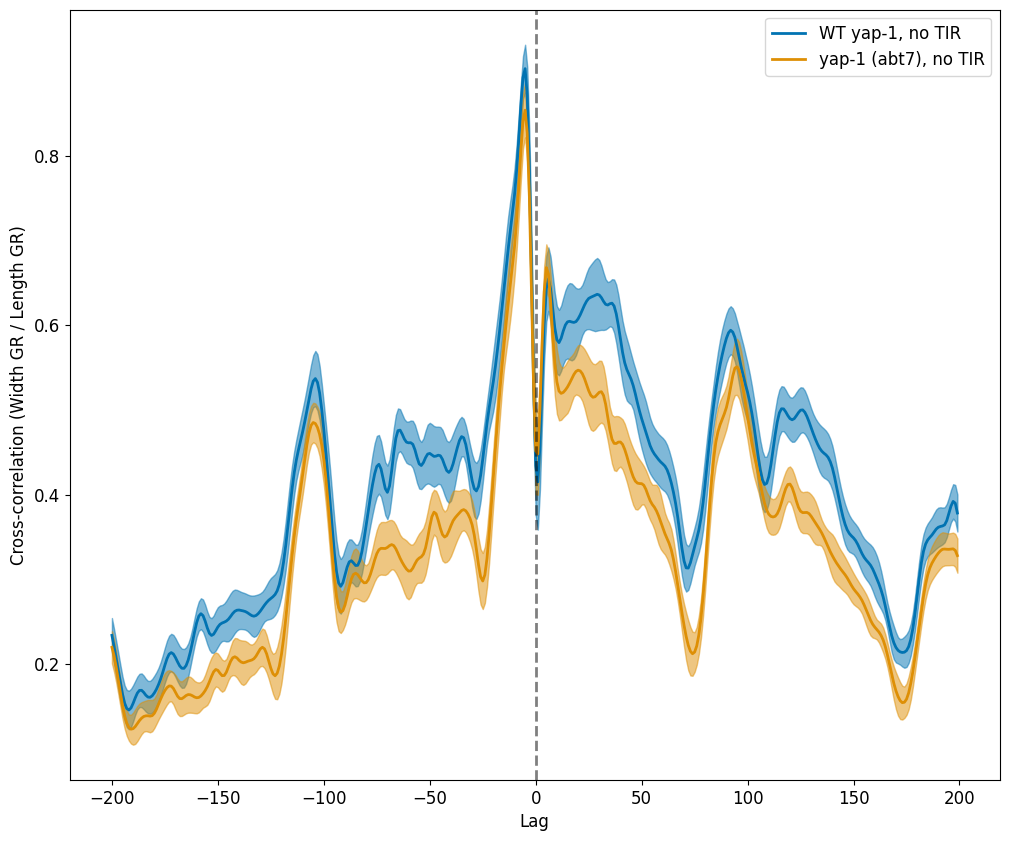

In [ ]:
plot_cross_correlation(conditions_struct, 'body_seg_str_width_mean_growth_rate_rescaled', 'body_seg_str_length_growth_rate_rescaled', [0, 4], x_axis_label='Lag', y_axis_label='Cross-correlation (Width GR / Length GR)', legend={'description': ''})

28
68


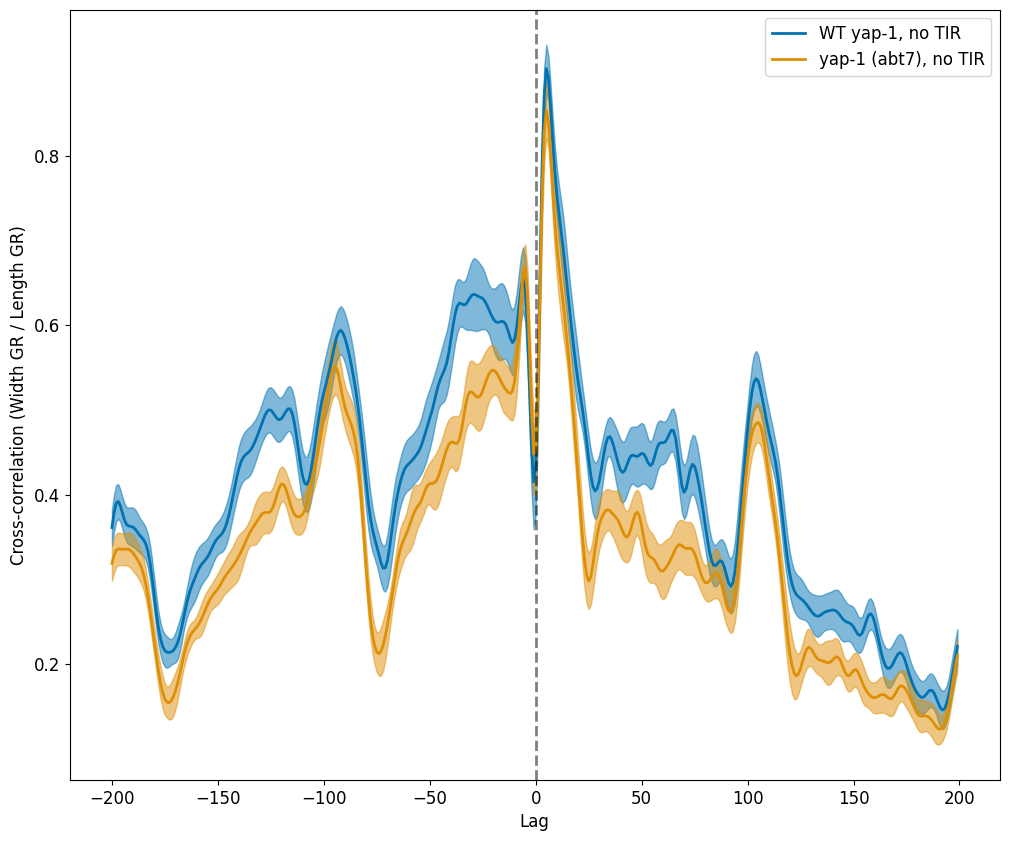

In [ ]:
plot_cross_correlation(conditions_struct, 'body_seg_str_length_growth_rate_rescaled', 'body_seg_str_width_mean_growth_rate_rescaled', [0, 4], x_axis_label='Lag', y_axis_label='Cross-correlation (Width GR / Length GR)', legend={'description': ''})

28
68


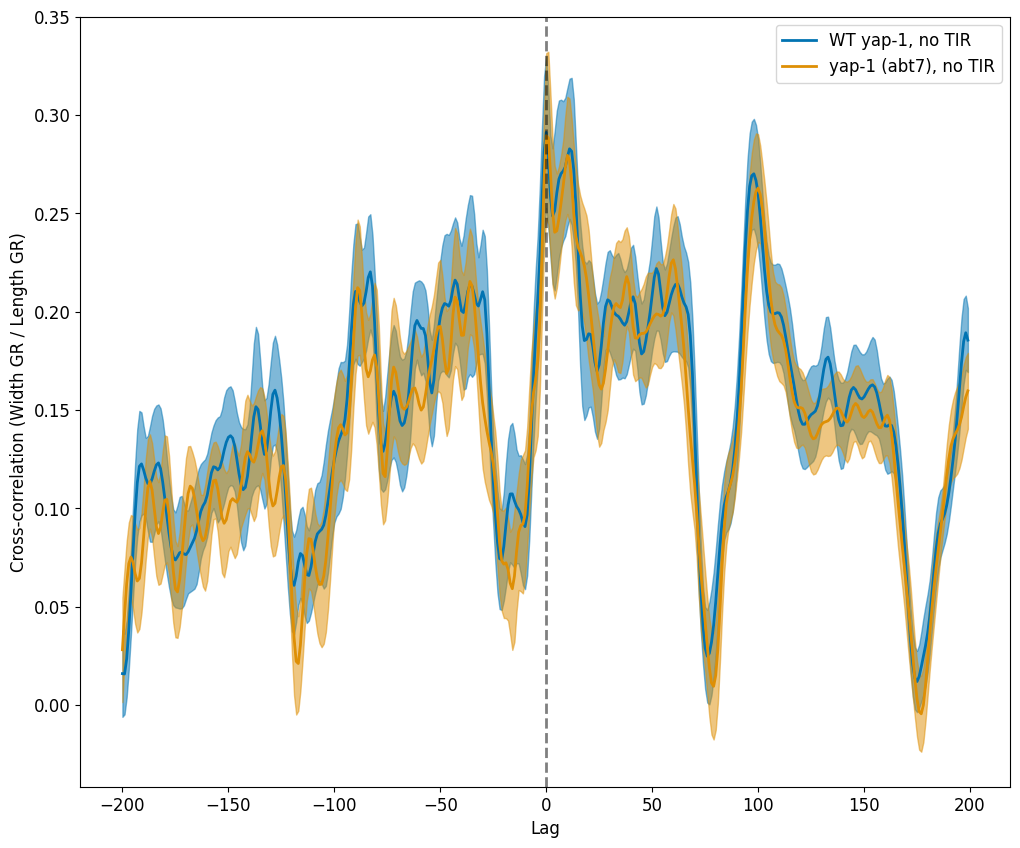

In [ ]:
plot_cross_correlation(conditions_struct, 'pharynx_seg_str_width_mean_growth_rate_rescaled', 'pharynx_seg_str_length_growth_rate_rescaled', [0, 4], x_axis_label='Lag', y_axis_label='Cross-correlation (Width GR / Length GR)', legend={'description': ''})

28
68


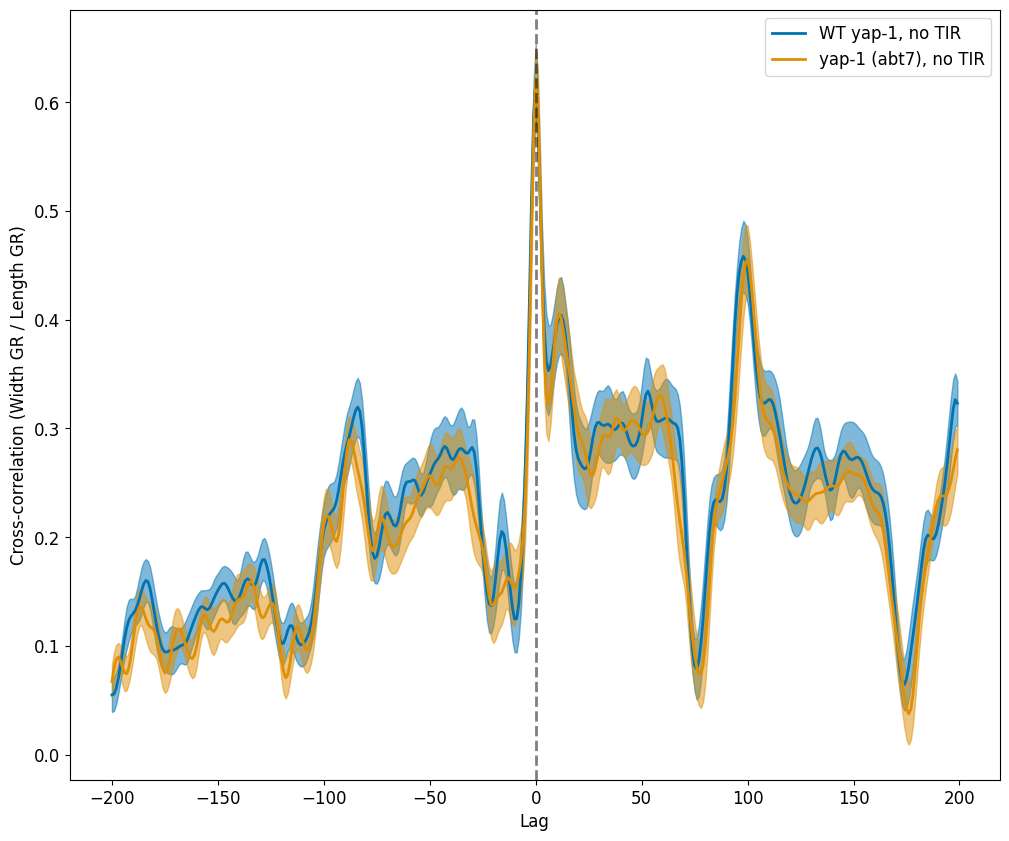

In [ ]:
plot_cross_correlation(conditions_struct, 'pharynx_seg_str_volume_growth_rate_rescaled', 'pharynx_seg_str_length_growth_rate_rescaled', [0, 4], x_axis_label='Lag', y_axis_label='Cross-correlation (Width GR / Length GR)', legend={'description': ''})

In [ ]:
# boxplot_at_molt(conditions_struct, 'larval_stage_durations_time_step', [0, 1, 2, 3], log_scale = False, plot_significance=True, legend = {'description': ''}, y_axis_label="Larval stage duration (time step)", titles = ['L1', 'L2', 'L3', 'L4'])

Condition 4, Molt 0, Selected indices: [30 87], Selected distances: [11.46093283 20.51991159], Selected points: [191 146], Selected ecdysis: [ 8 10]
['/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/ch1_seg_str/Time00008_Point0191_Channel470 nm,575,DIA_Seq2927.tiff']
(21, 86)


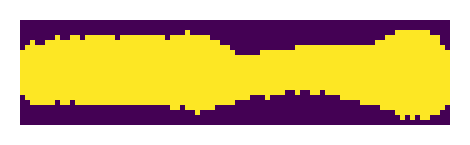

['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00010_Point0146_Channel470 nm,575,DIA_Seq2326.tiff']
(21, 85)


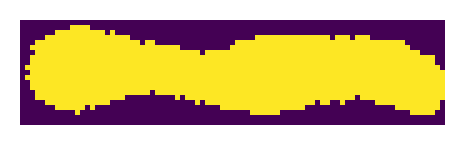

Condition 4, Molt 1, Selected indices: [92 91], Selected distances: [1.09372789 8.10878741], Selected points: [151 150], Selected ecdysis: [102 111]
['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00102_Point0151_Channel470 nm,575,DIA_Seq22387.tiff']
(25, 110)


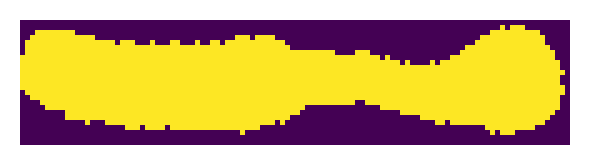

['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00111_Point0150_Channel470 nm,575,DIA_Seq24348.tiff']
(28, 112)


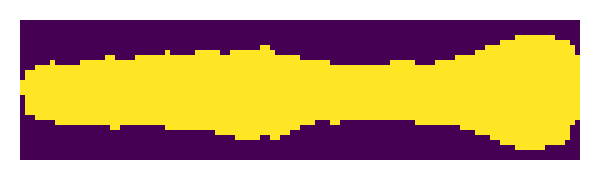

Condition 4, Molt 2, Selected indices: [15 55], Selected distances: [ 3.97472635 15.31385624], Selected points: [176 114], Selected ecdysis: [125 156]
['/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/ch1_seg_str/Time00125_Point0176_Channel470 nm,575,DIA_Seq42926.tiff']
(31, 128)


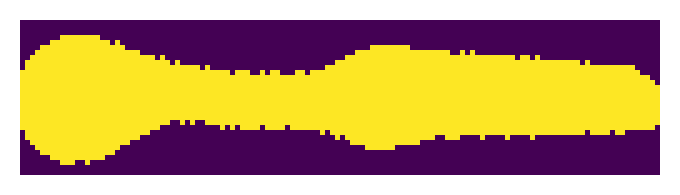

['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00156_Point0114_Channel470 nm,575,DIA_Seq34122.tiff']
(31, 119)


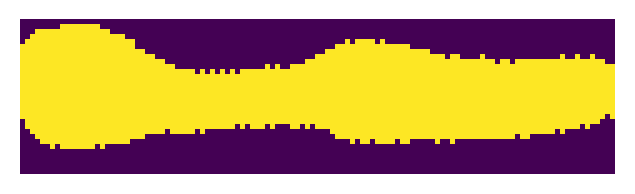

Condition 4, Molt 3, Selected indices: [ 8 81], Selected distances: [15.72523353 26.03645316], Selected points: [169 140], Selected ecdysis: [172 169]
['/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/ch1_seg_str/Time00172_Point0169_Channel470 nm,575,DIA_Seq58993.tiff']
(36, 147)


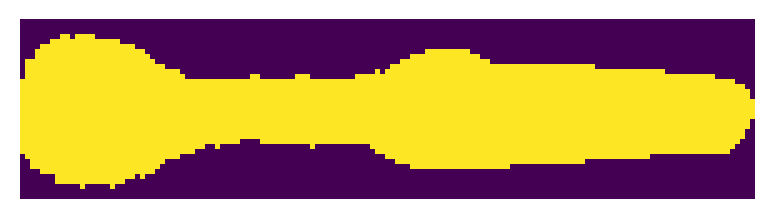

['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00169_Point0140_Channel470 nm,575,DIA_Seq36982.tiff']
(38, 148)


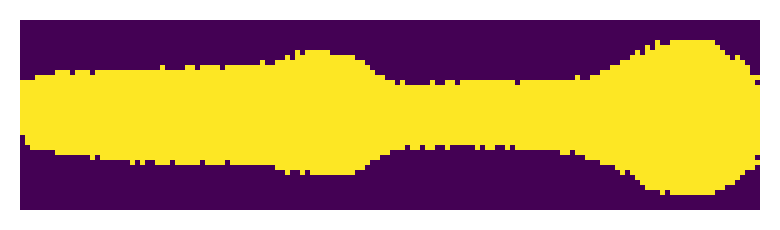

Condition 4, Molt 4, Selected indices: [42 87], Selected distances: [33.95245074 36.56789871], Selected points: [203 146], Selected ecdysis: [266 245]
['/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/ch1_seg_str/Time00266_Point0203_Channel470 nm,575,DIA_Seq91175.tiff']
(45, 166)


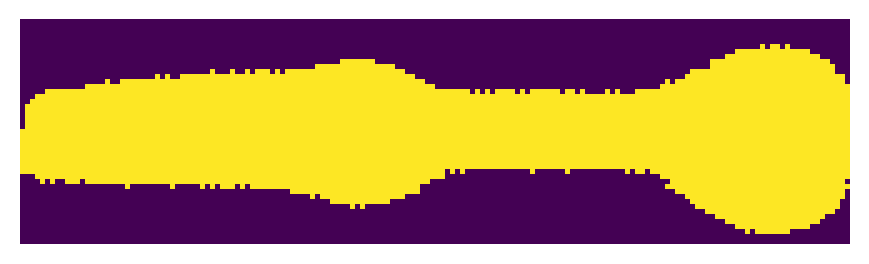

['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00245_Point0146_Channel470 nm,575,DIA_Seq53556.tiff']
(43, 170)


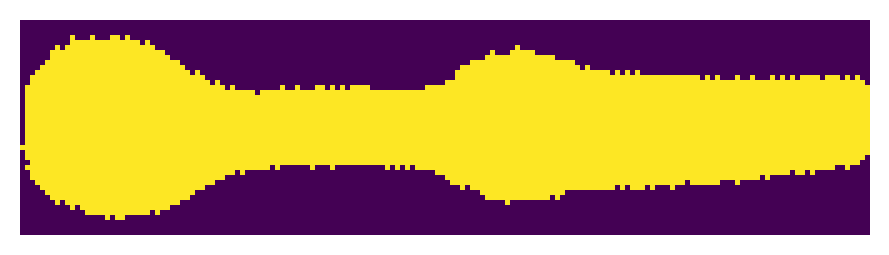

In [ ]:
from typing import Dict, List, Any, Tuple
from towbintools.foundation.image_handling import read_tiff_file

def exclude_arrests_from_series_at_ecdysis(series_at_ecdysis):
    filtered_series = np.full(series_at_ecdysis.shape, np.nan)
    # keep only a value at one ecdys event if the next one is not nan
    if series_at_ecdysis.shape[0] == 1 or len(series_at_ecdysis.shape) == 1:
        for i in range(len(series_at_ecdysis)):
            if i == len(series_at_ecdysis) - 1:
                filtered_series[i] = series_at_ecdysis[i]
            elif not np.isnan(series_at_ecdysis[i + 1]):
                filtered_series[i] = series_at_ecdysis[i]
        return filtered_series
    else:
        for i in range(series_at_ecdysis.shape[0]):
            for j in range(series_at_ecdysis.shape[1]):
                if j == series_at_ecdysis.shape[1] - 1:
                    filtered_series[i, j] = series_at_ecdysis[i, j]
                elif not np.isnan(series_at_ecdysis[i, j + 1]):
                    filtered_series[i, j] = series_at_ecdysis[i, j]
        return filtered_series

def process_series_at_ecdysis(
    series: np.ndarray,
    ecdysis: np.ndarray,
    remove_hatch: bool = True,
    exclude_arrests: bool = False
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Process and clean the input single series data.
    """
    if remove_hatch:
        series = series[:, 1:]
        ecdysis = ecdysis[:, 1:]
    if exclude_arrests:
        series = exclude_arrests_from_series_at_ecdysis(series)

    # Remove nan elements
    for i in range(series.shape[1]):
        nan_mask = np.isnan(series[:, i])
        series[:, i][nan_mask] = np.nan

    return series, ecdysis

def filter_non_worm_data(
    data: np.ndarray,
    worm_type: np.ndarray,
    ecdysis: np.ndarray
) -> np.ndarray:
    """
    Filter out non-worm data points.
    """
    filtered_data = data.copy()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            try:
                if ~(np.isnan(data[i][j])) and worm_type[i][int(ecdysis[i][j])] != 'worm':
                    filtered_data[i][j] = np.nan
            except ValueError:
                filtered_data[i][j] = np.nan
    return filtered_data

def get_condition_filemaps(
    condition_dict: Dict,
) -> Dict[str, Any]:
    """
    Set up file mappings for image directories.
    """
    filemap_paths = condition_dict['filemap_path']
    unique_filemap_paths = np.unique(filemap_paths)
    filemaps = {}
    
    for filemap_path in unique_filemap_paths:
        filemap = pd.read_csv(filemap_path)
        filemaps[filemap_path] = filemap
    return filemaps

def keep_selected_columns(filemap_dict: Dict[str, Any], columns_to_keep) -> Dict[str, Any]:

    columns = columns_to_keep.copy()
    if 'Point' not in columns:
        columns.append('Point')
    if 'Time' not in columns:
        columns.append('Time')

    for key, filemap in filemap_dict.items():
        filemap = filemap[columns]
        filemap_dict[key] = filemap
    
    return filemap_dict

def get_image_paths_of_time_point(point, time, filemap_path_of_point, filemaps, image_columns):
    filemap_of_point = filemaps[filemap_path_of_point]
    filemap_of_point = filemap_of_point[filemap_of_point['Point'] == point]
    filemap_of_point = filemap_of_point[filemap_of_point['Time'] == time]

    image_paths = filemap_of_point[image_columns].values.flatten().tolist()

    return image_paths

def display_image(
    img_path: str,
    dpi: int = 300,
    scale: float = 1.0,
    cmap: str = 'viridis',
    backup_dir: str = None,
    backup_file_name: str = None,
) -> None:
    """
    Display an image with the specified parameters.
    """
    img = read_tiff_file(img_path)
    print(img.shape)

    if backup_dir is not None:
        if backup_file_name is not None:
            shutil.copy(img_path, os.path.join(backup_dir, backup_file_name))
        else:
            shutil.copy(img_path, backup_dir)
    height, width = img.shape[-2:]
    
    fig = plt.figure(figsize=((width/dpi) * scale, (height/dpi)* scale), dpi=dpi)
    plt.imshow(img, interpolation='none', aspect='equal', cmap=cmap)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.axis('off')
    plt.show()

def new_get_most_average_size_at_ecdysis(
    conditions_struct: Dict,
    column : str,
    img_dir_list: List[str],
    conditions_to_plot: List[int],
    remove_hatch: bool = True,
    exclude_arrests: bool = False,
    dpi: int = 200,
    scale: float = 1.0,
    nb_per_condition: int = 1,
    overlay: bool = True,
    cmap: List[str] = 'viridis',
    backup_dir: str = None,
    backup_name = None,
) -> None:
    """
    Calculate and display the most average sizes at ecdysis.
    """
    for condition_id in conditions_to_plot:
        condition = conditions_struct[condition_id]
        # TEMPORARY, ONLY WORKS WITH SINGLE CLASSIFICATION, FIND A WAY TO GENERALIZE
        worm_type_key = [key for key in condition.keys() if "worm_type" in key][0]

        series, point, experiment, ecdysis, worm_type = [
            condition[key] for key in [column, 'point', 'experiment', 'ecdysis_time_step', worm_type_key]
        ]

        filemaps = get_condition_filemaps(condition)
        filemaps = keep_selected_columns(filemaps, img_dir_list)
        
        series, ecdysis = process_series_at_ecdysis(
            series, ecdysis, remove_hatch, exclude_arrests
        )

        series = filter_non_worm_data(series, worm_type, ecdysis)

        series_mean = np.nanmean(series, axis=0)

        for i in range(series.shape[1]):
            series_molt = series[:, i]
            series_mean_molt = series_mean[i]

            distance_score = np.abs(series_molt - series_mean_molt)
    
            sorted_idx = np.argsort(distance_score)
            selected_idx = sorted_idx[:nb_per_condition]

            point_of_indices = point[selected_idx].squeeze().astype(int)
            ecdysis_of_indices = ecdysis[selected_idx, i].squeeze().astype(int)
            filemap_paths_of_indices = condition['filemap_path'][selected_idx].squeeze()

            print(f'Condition {condition_id}, Molt {i}, Selected indices: {selected_idx}, Selected distances: {distance_score[selected_idx]}, Selected points: {point_of_indices}, Selected ecdysis: {ecdysis_of_indices}')

            for i, (p, t, filemap_path) in enumerate(zip(point_of_indices, ecdysis_of_indices, filemap_paths_of_indices)):
                image_paths = get_image_paths_of_time_point(p, t, filemap_path, filemaps, img_dir_list)
                print(image_paths)

                display_image(
                    image_paths[0],
                    dpi,
                    scale,
                    cmap,
                )

            #     display_sample_images(
            #         image_paths,
            #         point,
            #         ecdysis,
            #         img_dir_list,
            #         filemaps,
            #         dpi,
            #         overlay=overlay,
            #         cmap=cmap,
            #     )

            # print(f"Condition {condition_id}, Molt {i}, Selected indices: {selected_idx}, Selected distances: {distance_score[selected_idx]}")
            
        #     for idx in valid_idx:
        #         display_sample_images(
        #             experiment[idx][0],
        #             int(point[idx][i]),
        #             int(ecdysis[idx][i]),
        #             img_dir_list,
        #             filemaps,
        #             dpi,
        #             overlay=overlay,
        #             cmap=cmap,
        #         )

new_get_most_average_size_at_ecdysis(
    conditions_struct,
    'pharynx_seg_str_volume_at_ecdysis',
    ['analysis_sacha/ch1_seg_str'],
    [4],
    remove_hatch=False,
    exclude_arrests=True,
    dpi=200,
    scale=5.0,
    nb_per_condition=2,
    cmap='viridis',
)

Condition 0, Molt 0, Selected indices: [40 34], Selected distances: [21.3158126  42.25314618], Selected points: [9 3], Selected ecdysis: [20 28]
['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00020_Point0009_Channel470 nm,575,DIA_Seq4369.tiff']
(23, 98)


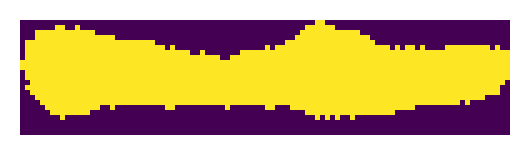

['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00028_Point0003_Channel470 nm,575,DIA_Seq6107.tiff']
(21, 100)


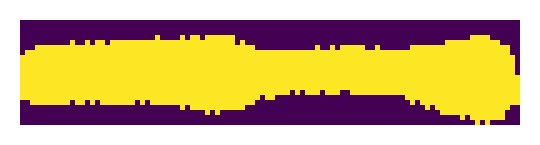

Condition 0, Molt 1, Selected indices: [38 19], Selected distances: [ 2.7493714  10.78774199], Selected points: [ 7 19], Selected ecdysis: [96 64]
['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00096_Point0007_Channel470 nm,575,DIA_Seq20935.tiff']
(26, 133)


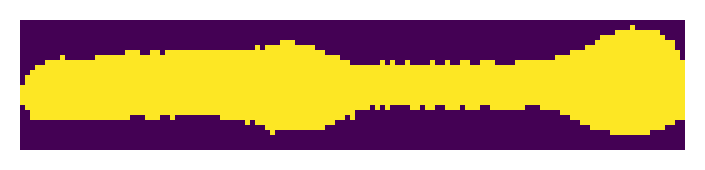

['/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/ch1_seg_str/Time00064_Point0019_Channel470 nm,575,DIA_Seq21907.tiff']
(26, 129)


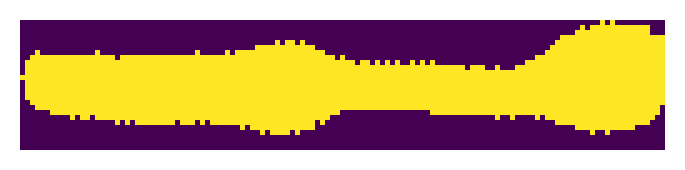

Condition 0, Molt 2, Selected indices: [26 55], Selected distances: [10.47397935 12.0194033 ], Selected points: [26 24], Selected ecdysis: [116 131]
['/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/ch1_seg_str/Time00116_Point0026_Channel470 nm,575,DIA_Seq39698.tiff']
(31, 148)


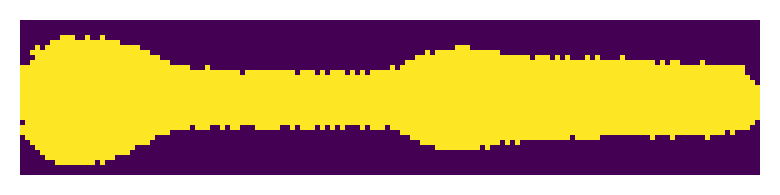

['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00131_Point0024_Channel470 nm,575,DIA_Seq28582.tiff']
(31, 153)


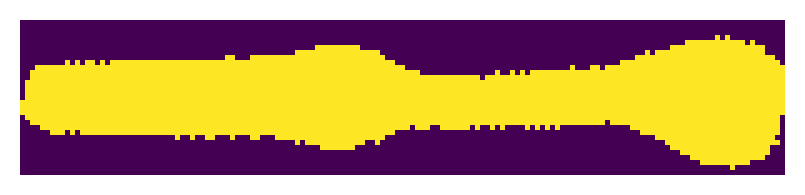

Condition 0, Molt 3, Selected indices: [39  6], Selected distances: [0.65167413 2.41934021], Selected points: [8 6], Selected ecdysis: [178 179]
['/mnt/towbin.data/shared/kstojanovski/20240212_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240212_164059_429/analysis_sacha/ch1_seg_str/Time00178_Point0008_Channel470 nm,575,DIA_Seq38812.tiff']
(36, 173)


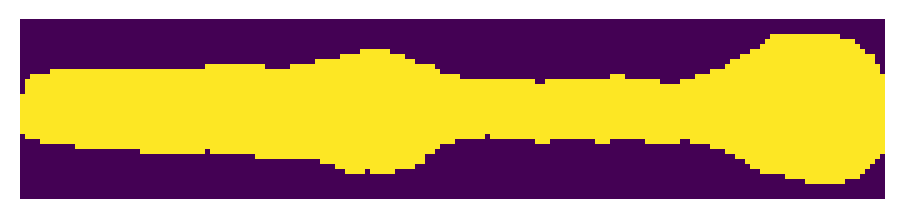

['/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/ch1_seg_str/Time00179_Point0006_Channel470 nm,575,DIA_Seq61224.tiff']
(36, 172)


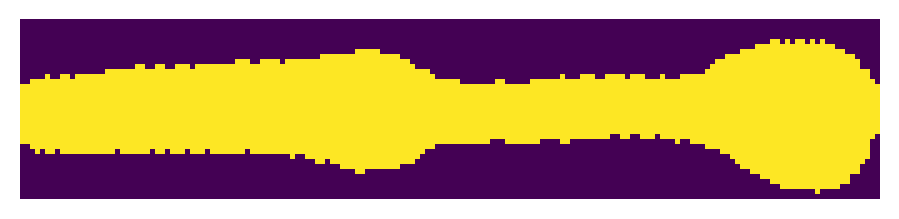

Condition 0, Molt 4, Selected indices: [13 27], Selected distances: [26.32111381 41.37472411], Selected points: [13 27], Selected ecdysis: [241 224]
['/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/ch1_seg_str/Time00241_Point0013_Channel470 nm,575,DIA_Seq82435.tiff']
(45, 200)


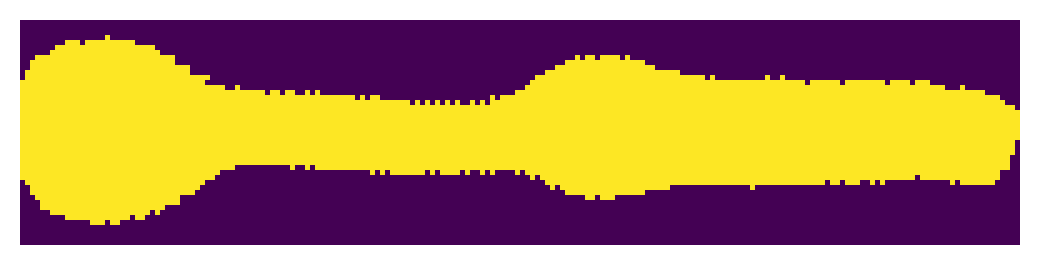

['/mnt/towbin.data/shared/kstojanovski/20240202_Orca_10x_yap-1del_col-10-tir_wBT160-186-310-337-380-393_25C_20240202_171239_051/analysis_sacha/ch1_seg_str/Time00224_Point0027_Channel470 nm,575,DIA_Seq76635.tiff']
(45, 192)


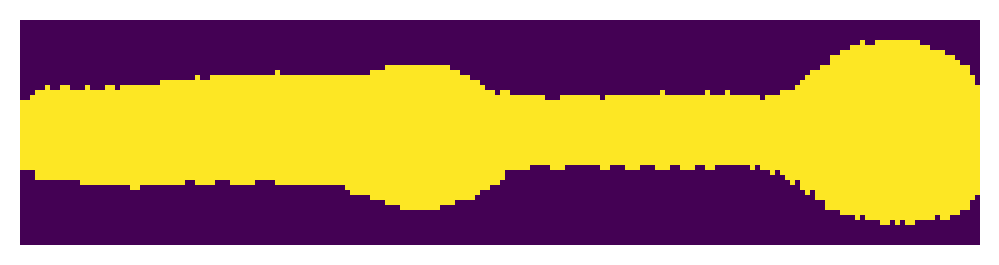

In [ ]:
new_get_most_average_size_at_ecdysis(
    conditions_struct,
    'pharynx_seg_str_volume_at_ecdysis',
    ['analysis_sacha/ch1_seg_str'],
    [0],
    remove_hatch=False,
    exclude_arrests=True,
    dpi=200,
    scale=5.0,
    nb_per_condition=2,
    cmap='viridis',
)

In [ ]:
# plot_arrests(conditions_struct, [0, 2, 4, 5], legend = {'description': ''})

In [ ]:
# get_most_average_size_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_width_mean_at_ecdysis',
#     ['analysis_sacha/ch2_seg_str'],
#     [4],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red'],
# )

In [ ]:
# get_most_average_size_at_ecdysis(
#     conditions_struct,
#     'pharynx_seg_str_volume_at_ecdysis',
#     ['analysis_sacha/ch1_seg_str'],
#     [4],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red'],
# )

In [ ]:
# get_most_average_proportions_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_length_at_ecdysis',
#     'body_seg_str_mean_width_at_ecdysis',
#     ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
#     [0],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red', 'pure_green'],
# )

In [ ]:
# get_most_average_proportions_at_ecdysis(
#     conditions_struct,
#     'body_seg_str_length_at_ecdysis',
#     'body_seg_str_volume_at_ecdysis',
#     ['analysis/ch2_raw_str', 'analysis/ch1_raw_str'],
#     [5],
#     remove_hatch=False,
#     exclude_arrests=True,
#     dpi=600,
#     nb_per_condition=2,
#     cmap=['pure_red', 'pure_green'],
# )